## Setup, Loading Data and CDFs

In [7]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [8]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_agriVision.ipynb


In [9]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/blue'

In [10]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [11]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [12]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


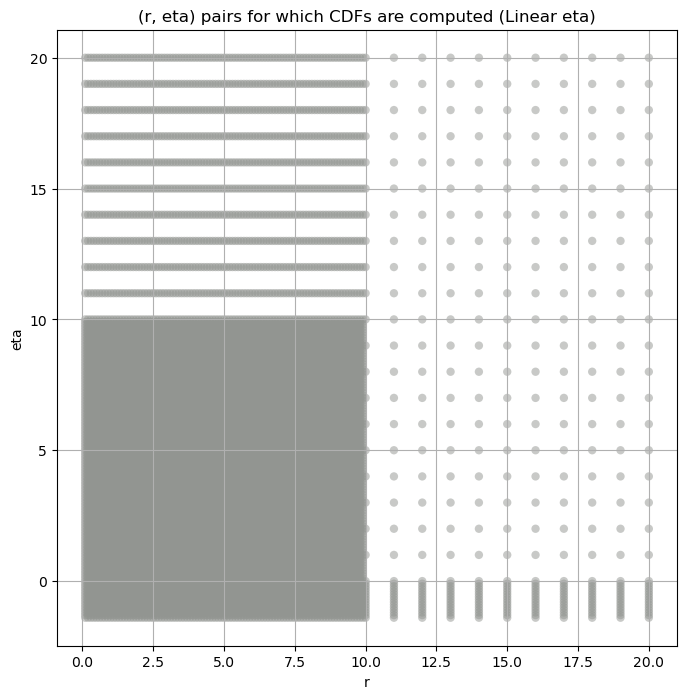

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [13]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [14]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [15]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:29<00:00, 3372.35it/s]


Layer 3


100%|██████████| 100000/100000 [00:31<00:00, 3198.79it/s]


Layer 4


100%|██████████| 100000/100000 [00:24<00:00, 4023.51it/s]


Layer 5


100%|██████████| 100000/100000 [00:25<00:00, 3994.14it/s]


Layer 6


100%|██████████| 100000/100000 [00:25<00:00, 3987.08it/s]


Layer 7


100%|██████████| 100000/100000 [00:24<00:00, 4005.20it/s]


Layer 8


100%|██████████| 100000/100000 [00:24<00:00, 4006.92it/s]


Layer 9


100%|██████████| 100000/100000 [00:24<00:00, 4004.38it/s]


Layer 10


100%|██████████| 100000/100000 [00:25<00:00, 3961.32it/s]


obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  
layer                             
2       760.94360         9000.0  
3       891.27313        36000.0  
4      1768.95340       144000.0  
5      2074.88330       576000.0  
6      3444.52950      2304000.0  
7      5672.12000      9216000.0  
8      4638.63770     36864000.0  
9      6105.37160    147456000.0  
10     7496.85840    589824000.0

## Initial Grid Search and Hypothesis Test Plots

In [16]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [17]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      188570.730000  188570.734375    53255.480469    45081.785156   
3       42568.312000   42568.312500    17821.275391    14721.261719   
4       10773.336000   10773.335938     5597.328125     4464.237793   
5        1800.434900    1800.434937      967.196716      795.382263   
6         390.887500     390.887512      192.203186      158.687836   
7          98.479220      98.479218       42.509384       35.698841   
8          33.173733      33.173733       16.510288       13.967173   
9          11.252635      11.252635        4.574734        3.848108   
10          1.875914       1.875914        0.641675        0.543280   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        40213.917969     36420.285156     30676.792969     26366.972656   
3        13259.316406     12236.730469     10732.189453      9663.358398   
4         3925.427979      3574.999512      3107.311768      2816.859863   
5          702.730896       642.706543       566.309204       515.472717   
6          141.026688       129.362122       114.128799       104.113617   
7           32.237232        29.994589        27.104929        25.205553   
8           12.692533        11.896943        10.898866        10.253603   
9            3.496440         3.280626         3.007298         2.824955   
10           0.494285         0.463169         0.422697         0.395412   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         23064.148438     20511.724609     18413.591797     13823.259766  
3          8833.767578      8160.319824      7600.590332      6365.457520  
4          2605.477295      2443.711670      2310.490234      2000.593140  
5           477.084412       446.199188       420.567810       363.674988  
6            96.796181        91.054344        86.336449        75.977577  
7            23.804392        22.697041        21.784376        19.744150  
8             9.773006         9.387711         9.064301         8.316109  
9             2.686348         2.573658         2.478288         2.256173  
10            0.374613         0.357785         0.343469         0.310336

####
Layer  2


100%|██████████| 12760/12760 [00:05<00:00, 2284.83it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.024703206473402184 188570.73


100%|██████████| 12760/12760 [00:04<00:00, 2829.96it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.014584253059125113 53255.48


100%|██████████| 12760/12760 [00:04<00:00, 2958.34it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.01602528170614148 45081.785


100%|██████████| 12760/12760 [00:03<00:00, 3291.24it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.016955365519082943 40213.918


100%|██████████| 12760/12760 [00:03<00:00, 3303.39it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.01841664117324246 36420.285


100%|██████████| 12760/12760 [00:03<00:00, 3252.68it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.022724438656800072 30676.793


100%|██████████| 12760/12760 [00:03<00:00, 3270.21it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.028851745438933762 26366.973


100%|██████████| 12760/12760 [00:04<00:00, 3159.96it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.03456475305424633 23064.148


100%|██████████| 12760/12760 [00:04<00:00, 3178.93it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.039377497110689295 20511.725


100%|██████████| 12760/12760 [00:04<00:00, 3138.62it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.04428543379979818 18413.592


100%|██████████| 12760/12760 [00:04<00:00, 3093.61it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.06005225276932091 13823.26
Number of samples: 9000, Without approximation : 9000.0


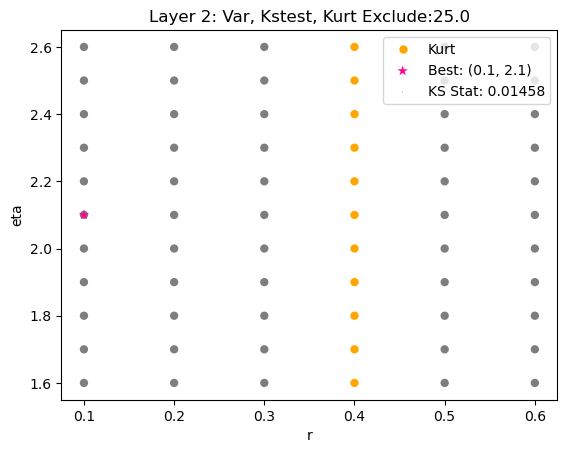

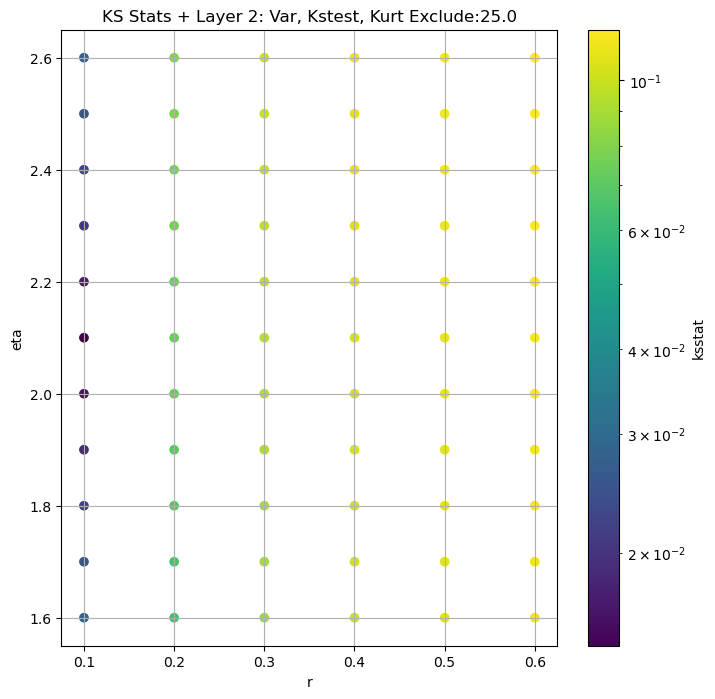

####
Layer  3


100%|██████████| 12760/12760 [00:16<00:00, 786.01it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.03196567196377875 42568.312


100%|██████████| 12760/12760 [00:15<00:00, 801.93it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.01923746782568503 17821.275


100%|██████████| 12760/12760 [00:16<00:00, 772.20it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.01623210737979086 14721.262


100%|██████████| 12760/12760 [00:15<00:00, 812.87it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.015428494181475905 13259.316


100%|██████████| 12760/12760 [00:15<00:00, 803.66it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.014178561687838709 12236.73


100%|██████████| 12760/12760 [00:16<00:00, 771.44it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.013810697149131634 10732.189


100%|██████████| 12760/12760 [00:15<00:00, 813.94it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.013127038969653282 9663.358


100%|██████████| 12760/12760 [00:15<00:00, 821.80it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.013850857180362386 8833.768


100%|██████████| 12760/12760 [00:15<00:00, 819.45it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.014670657501892559 8160.32


100%|██████████| 12760/12760 [00:15<00:00, 803.89it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.016614915110212625 7600.5903


100%|██████████| 12760/12760 [00:15<00:00, 820.81it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.019207573752320073 6365.4575
Number of samples: 36000, Without approximation : 36000.0


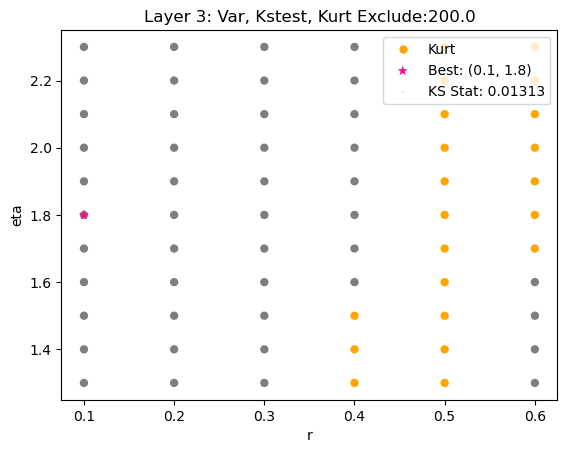

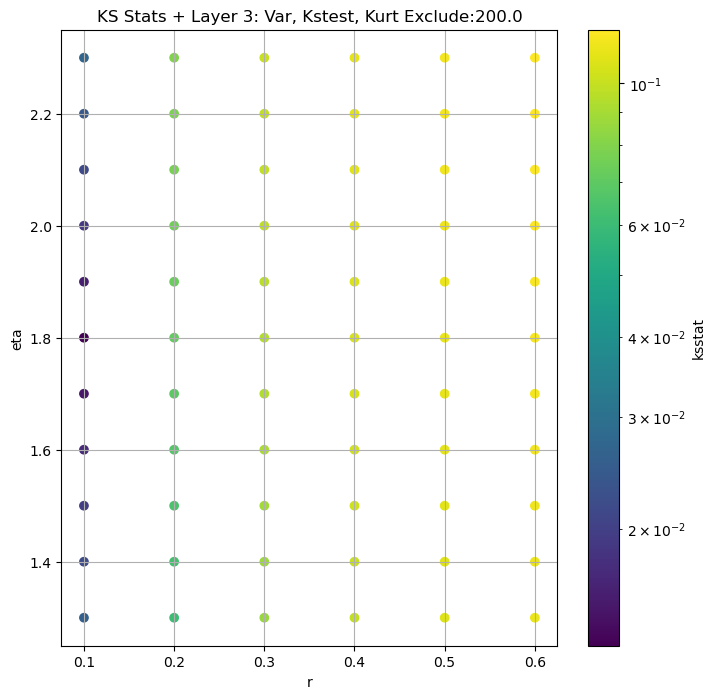

####
Layer  4


100%|██████████| 12760/12760 [00:44<00:00, 288.98it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.03354163578664715 10773.336


100%|██████████| 12760/12760 [00:44<00:00, 287.34it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.023781790824609073 5597.328


100%|██████████| 12760/12760 [00:44<00:00, 288.79it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.01961141193031468 4464.238


100%|██████████| 12760/12760 [00:44<00:00, 288.33it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.01900943368888708 3925.428


100%|██████████| 12760/12760 [00:44<00:00, 285.78it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.01744561898007191 3574.9995


100%|██████████| 12760/12760 [00:44<00:00, 285.21it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.013612789796330294 3107.3118


100%|██████████| 12760/12760 [00:44<00:00, 289.65it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.013357856540665458 2816.8599


100%|██████████| 12760/12760 [00:43<00:00, 291.22it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.011617680288428078 2605.4773


100%|██████████| 12760/12760 [00:44<00:00, 284.53it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010699775920562177 2443.7117


100%|██████████| 12760/12760 [00:47<00:00, 268.65it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.01010964594953942 2310.4902


100%|██████████| 12760/12760 [00:44<00:00, 283.73it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.009242374653490315 2000.5931
Number of samples: 100000, Without approximation : 144000.0


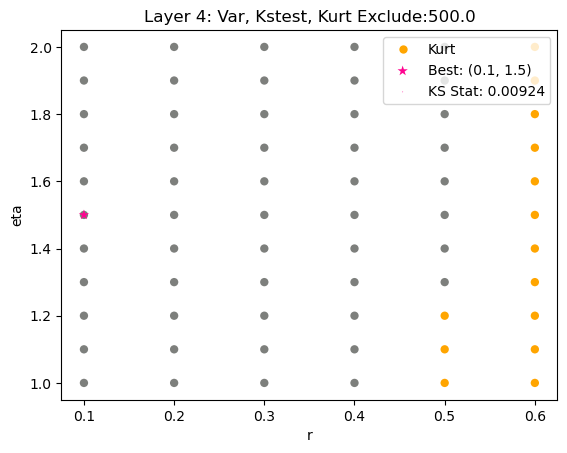

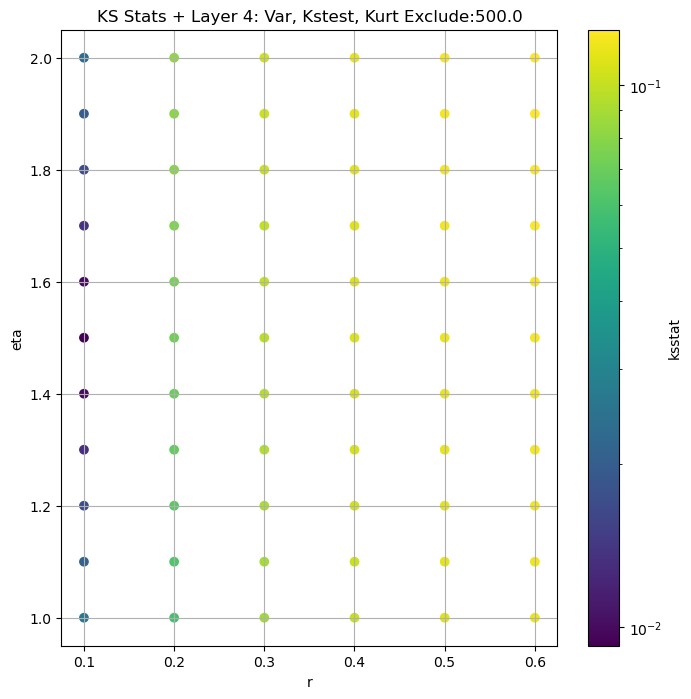

####
Layer  5


100%|██████████| 12760/12760 [00:44<00:00, 287.56it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03175293708651794 1800.4349


100%|██████████| 12760/12760 [00:44<00:00, 289.57it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.022099263039342926 967.1967


100%|██████████| 12760/12760 [00:43<00:00, 290.40it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.018534141817437344 795.38226


100%|██████████| 12760/12760 [00:43<00:00, 292.14it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.015023934939005446 702.7309


100%|██████████| 12760/12760 [00:44<00:00, 289.18it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.014137130852117541 642.70654


100%|██████████| 12760/12760 [00:43<00:00, 290.37it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.010992590866670704 566.3092


100%|██████████| 12760/12760 [00:44<00:00, 289.94it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.010360063986118495 515.4727


100%|██████████| 12760/12760 [00:44<00:00, 287.93it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.007882341219130978 477.0844


100%|██████████| 12760/12760 [00:44<00:00, 289.92it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.0073213386333245145 446.1992


100%|██████████| 12760/12760 [00:44<00:00, 288.92it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.0069412620391117175 420.5678


100%|██████████| 12760/12760 [00:43<00:00, 290.59it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008233251522350216 363.675
Number of samples: 100000, Without approximation : 576000.0


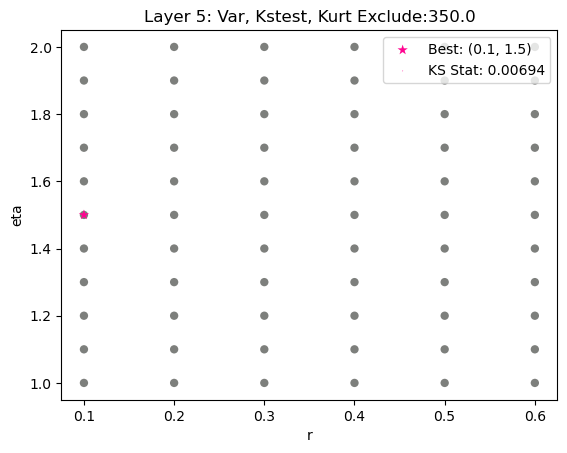

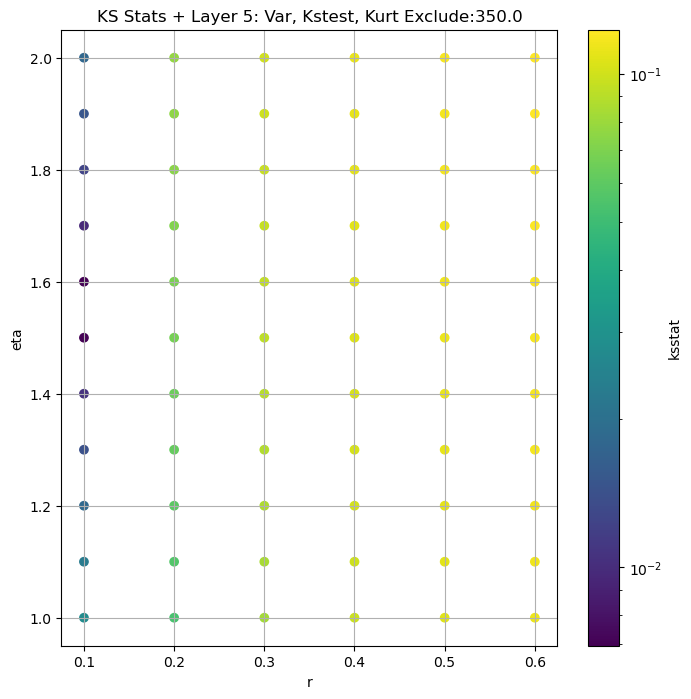

####
Layer  6


100%|██████████| 12760/12760 [00:44<00:00, 289.15it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.03348341263768853 390.8875


100%|██████████| 12760/12760 [00:44<00:00, 289.45it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.02053643428375973 192.20319


100%|██████████| 12760/12760 [00:44<00:00, 287.38it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.015393708328604594 158.68784


100%|██████████| 12760/12760 [00:43<00:00, 291.10it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.013041657205199286 141.02669


100%|██████████| 12760/12760 [00:44<00:00, 289.46it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.010946635461152293 129.36212


100%|██████████| 12760/12760 [00:44<00:00, 289.81it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.008408582864684419 114.1288


100%|██████████| 12760/12760 [00:44<00:00, 288.70it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.006052777170225454 104.11362


100%|██████████| 12760/12760 [00:44<00:00, 288.85it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.0048085447975213524 96.79618


100%|██████████| 12760/12760 [00:44<00:00, 284.62it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.004748627089042667 91.054344


100%|██████████| 12760/12760 [00:45<00:00, 283.33it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005330867172817388 86.33645


100%|██████████| 12760/12760 [00:44<00:00, 285.62it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.007172960321124466 75.97758
Number of samples: 100000, Without approximation : 2304000.0


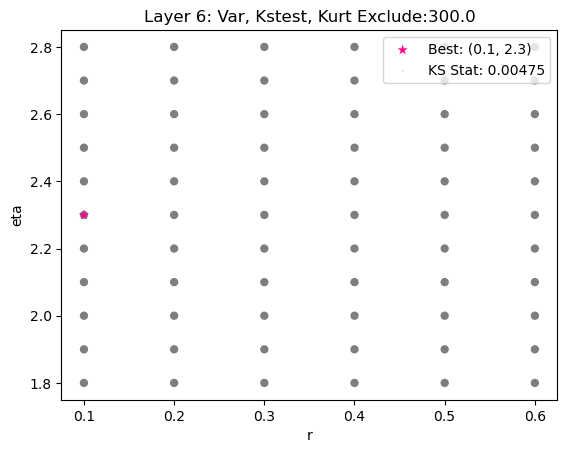

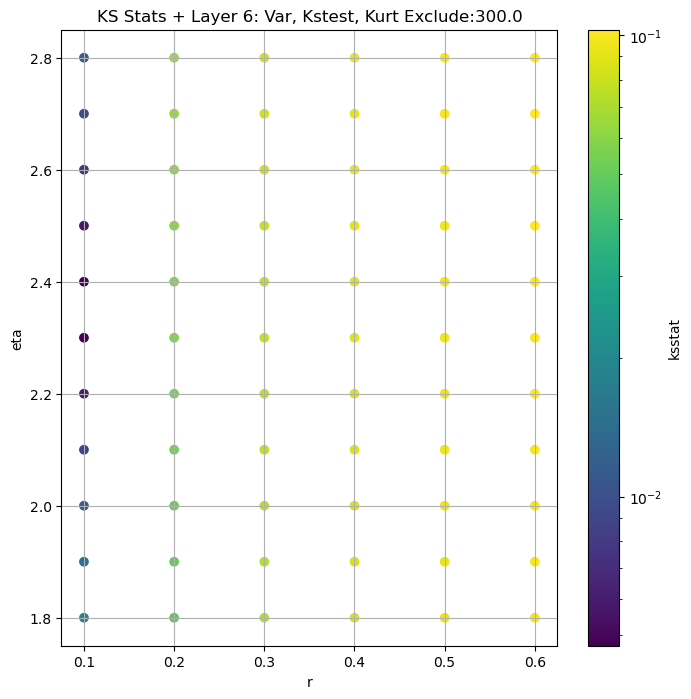

####
Layer  7


100%|██████████| 12760/12760 [00:44<00:00, 286.69it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.0333210100942235 98.47922


100%|██████████| 12760/12760 [00:44<00:00, 287.42it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.015286675836784669 42.509384


100%|██████████| 12760/12760 [00:45<00:00, 282.87it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.011019746742996994 35.69884


100%|██████████| 12760/12760 [00:45<00:00, 282.67it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.00862157022082466 32.237232


100%|██████████| 12760/12760 [00:45<00:00, 282.03it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006431607969142661 29.994589


100%|██████████| 12760/12760 [00:45<00:00, 279.08it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.004130332185802721 27.104929


100%|██████████| 12760/12760 [00:45<00:00, 278.48it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.004028962758290122 25.205553


100%|██████████| 12760/12760 [00:45<00:00, 278.80it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.003924006063943386 23.804392


100%|██████████| 12760/12760 [00:45<00:00, 281.35it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.004396267459136016 22.69704


100%|██████████| 12760/12760 [00:45<00:00, 280.95it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.004980462485143611 21.784376


100%|██████████| 12760/12760 [00:45<00:00, 278.32it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.006795886441518295 19.74415
Number of samples: 100000, Without approximation : 9216000.0


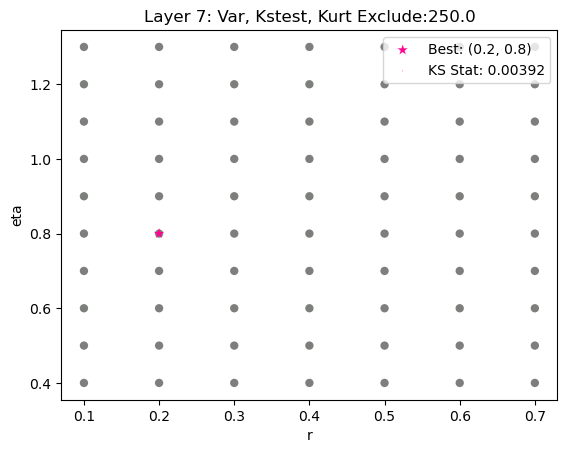

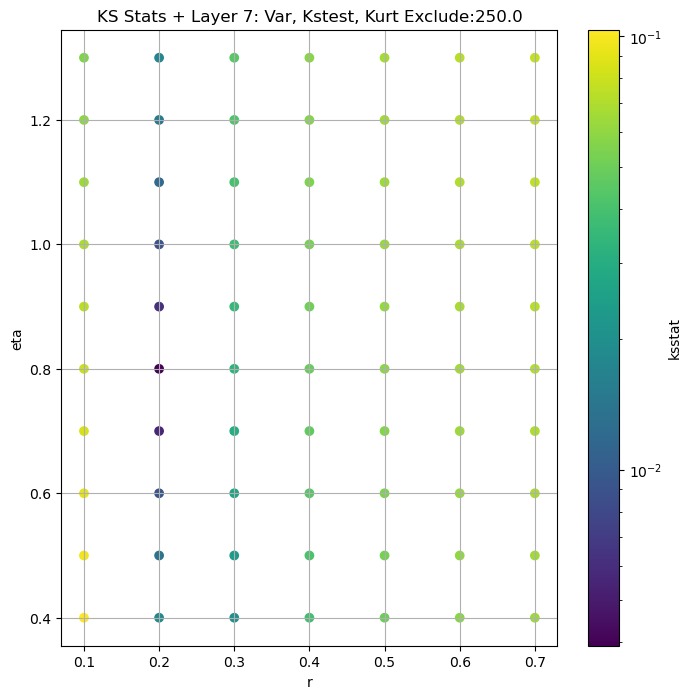

####
Layer  8


100%|██████████| 12760/12760 [00:45<00:00, 278.49it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.026145692394762776 33.173733


100%|██████████| 12760/12760 [00:45<00:00, 278.45it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.01004397708815874 16.510288


100%|██████████| 12760/12760 [00:45<00:00, 282.35it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.0059664869722586555 13.967173


100%|██████████| 12760/12760 [00:45<00:00, 282.19it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0035521237225065727 12.692533


100%|██████████| 12760/12760 [00:46<00:00, 276.16it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.0033500000000000196 11.896943


100%|██████████| 12760/12760 [00:45<00:00, 278.45it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.0033500000000000196 10.898866


100%|██████████| 12760/12760 [00:45<00:00, 280.10it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.0033499999999979657 10.253603


100%|██████████| 12760/12760 [00:45<00:00, 279.71it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.0035982971440601252 9.773006


100%|██████████| 12760/12760 [00:45<00:00, 279.94it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.004337272783743074 9.387711


100%|██████████| 12760/12760 [00:45<00:00, 281.15it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.005016746277420325 9.064301


100%|██████████| 12760/12760 [00:45<00:00, 278.80it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.006915672283515195 8.316109
Number of samples: 100000, Without approximation : 36864000.0


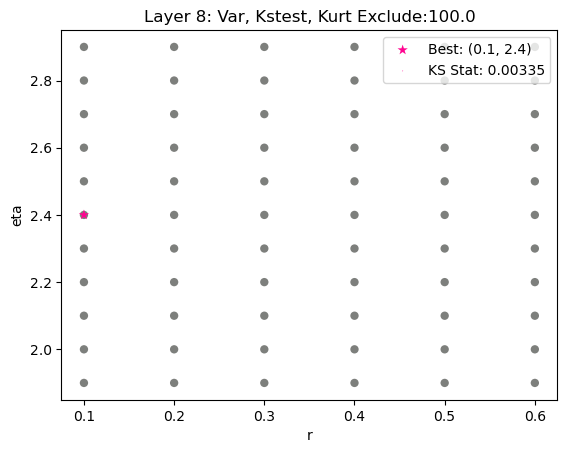

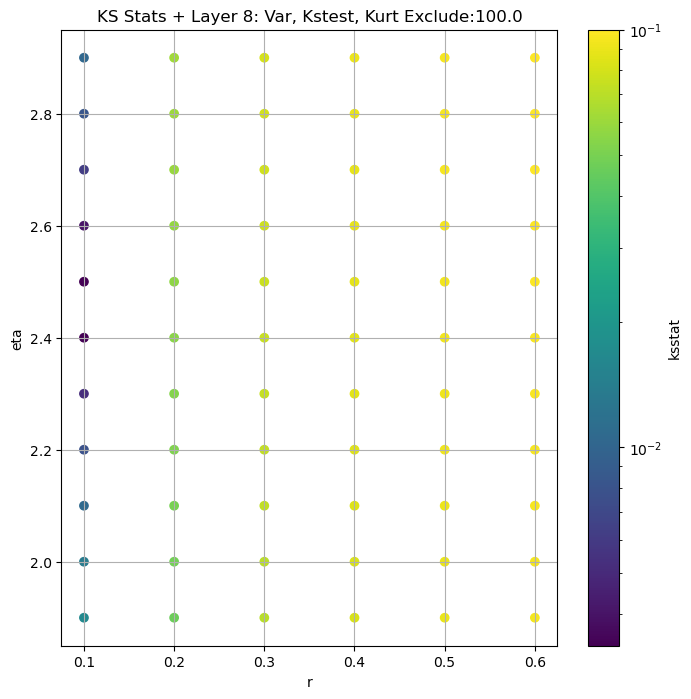

####
Layer  9


100%|██████████| 12760/12760 [00:46<00:00, 276.90it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.029963165806918712 11.252635


100%|██████████| 12760/12760 [00:45<00:00, 277.72it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.011653635828399067 4.5747337


100%|██████████| 12760/12760 [00:45<00:00, 277.82it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.007058840026735236 3.8481076


100%|██████████| 12760/12760 [00:46<00:00, 277.08it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.005950000000000177 3.4964397


100%|██████████| 12760/12760 [00:45<00:00, 279.08it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.005950000000000066 3.2806263


100%|██████████| 12760/12760 [00:45<00:00, 280.44it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.005949999999990796 3.0072985


100%|██████████| 12760/12760 [00:45<00:00, 279.98it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.005949999999991018 2.8249547


100%|██████████| 12760/12760 [00:45<00:00, 280.67it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.005949999999990796 2.686348


100%|██████████| 12760/12760 [00:45<00:00, 280.63it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.005949999999991018 2.5736582


100%|██████████| 12760/12760 [00:45<00:00, 281.10it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.005949999999991018 2.4782884


100%|██████████| 12760/12760 [00:45<00:00, 279.80it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.007334531173537662 2.2561734
Number of samples: 100000, Without approximation : 147456000.0


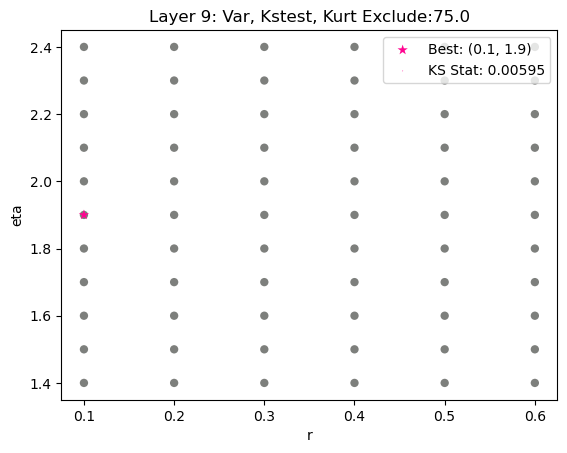

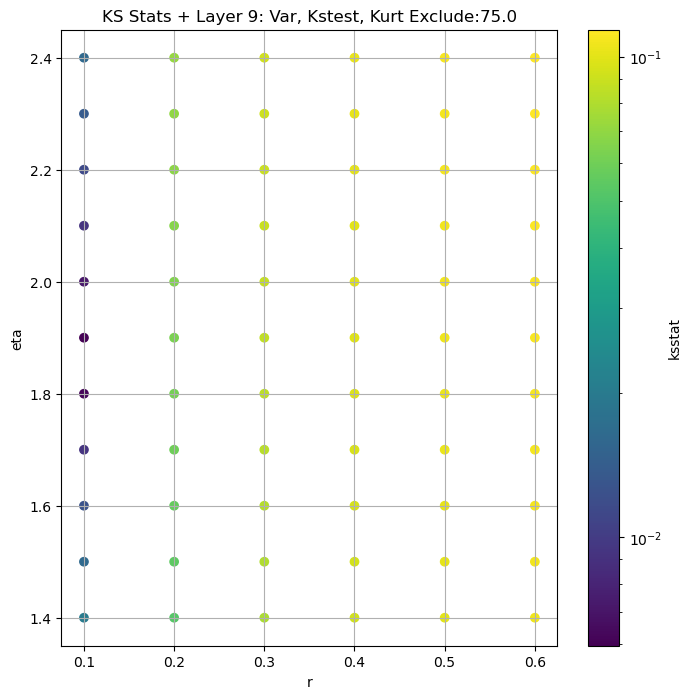

####
Layer  10


100%|██████████| 12760/12760 [00:44<00:00, 286.42it/s]


Finding Minimum after computing 12760 CDFs
10 0 0.034340066197014504 1.8759142


100%|██████████| 12760/12760 [00:44<00:00, 284.87it/s]


Finding Minimum after computing 12760 CDFs
10 25 0.02609999999998963 0.6416747


100%|██████████| 12760/12760 [00:45<00:00, 277.40it/s]


Finding Minimum after computing 12760 CDFs
10 50 0.026099999999989576 0.5432802


100%|██████████| 12760/12760 [00:45<00:00, 279.21it/s]


Finding Minimum after computing 12760 CDFs
10 75 0.02609999999998741 0.4942845


100%|██████████| 12760/12760 [00:48<00:00, 265.58it/s]


Finding Minimum after computing 12760 CDFs
10 100 0.026099999999986967 0.4631687


100%|██████████| 12760/12760 [00:48<00:00, 263.50it/s]


Finding Minimum after computing 12760 CDFs
10 150 0.02609999999998286 0.42269677


100%|██████████| 12760/12760 [00:48<00:00, 264.37it/s]


Finding Minimum after computing 12760 CDFs
10 200 0.026099999999981804 0.39541236


100%|██████████| 12760/12760 [00:48<00:00, 263.26it/s]


Finding Minimum after computing 12760 CDFs
10 250 0.02609999999998125 0.3746135


100%|██████████| 12760/12760 [00:49<00:00, 260.23it/s]


Finding Minimum after computing 12760 CDFs
10 300 0.02609999999998397 0.35778508


100%|██████████| 12760/12760 [00:48<00:00, 264.16it/s]


Finding Minimum after computing 12760 CDFs
10 350 0.026099999999983636 0.34346884


100%|██████████| 12760/12760 [00:50<00:00, 255.18it/s]


Finding Minimum after computing 12760 CDFs
10 500 0.026099999999983248 0.3103359
Number of samples: 100000, Without approximation : 589824000.0


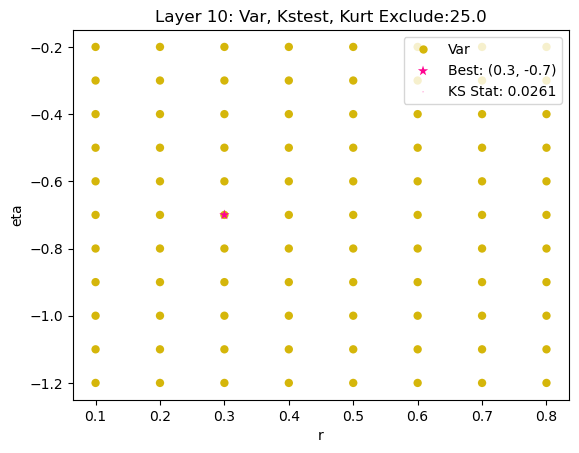

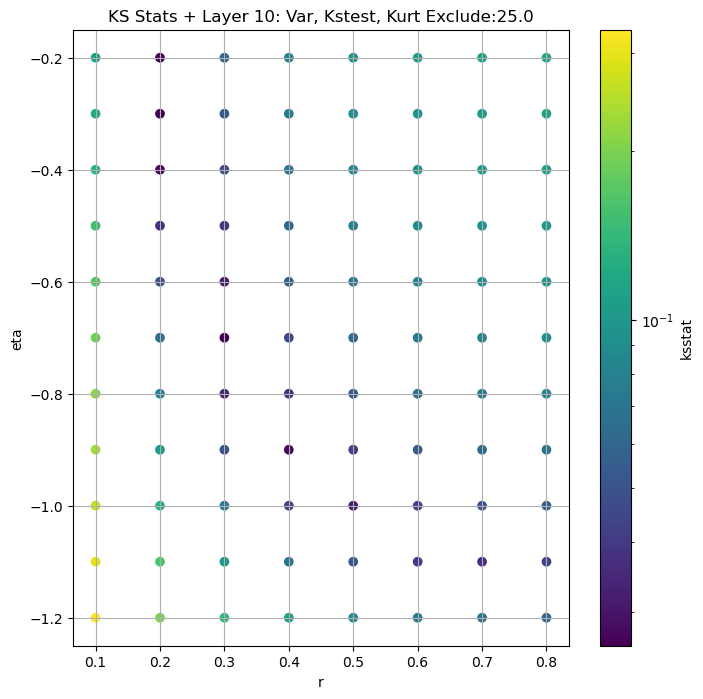

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       760.94360         9000.0             0.014584        0.1          2.1   
3       891.27313        36000.0             0.013127        0.1          1.8   
4      1768.95340       144000.0             0.009242        0.1          1.5   
5      2074.88330       576000.0             0.006941        0.1          1.5   
6      3444.52950      2304000.0             0.004749        0.1          2.3   
7      5672.12000      9216000.0             0.003924        0.2          0.8   
8      4638.63770     36864000.0             0.003350        0.1          2.4   
9      6105.37160    147456000.0             0.005950        0.1          1.9   
10     7496.85840    589824000.0             0.026100        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.600289e-12                    25.0        53255.480000   
3       1.809763e-12                   200.0         9663.358000   
4       8.671865e-13                   500.0         2000.593100   
5       1.823013e-13                   350.0          420.567800   
6       4.845850e-15                   300.0           91.054344   
7       5.457777e-05                   250.0           23.804392   
8       5.012416e-16                   100.0           11.896943   
9       5.025335e-16                    75.0            3.496440   
10      8.045400e-03                    25.0            0.641675   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [18]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [19]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 522/522 [00:00<00:00, 1307.29it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.024072701912019934, var: 33320.98828125


100%|██████████| 522/522 [00:00<00:00, 2662.56it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.021434438954339607, var: 36420.28515625


100%|██████████| 522/522 [00:00<00:00, 3329.35it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.018531568206211158, var: 40213.91796875


100%|██████████| 522/522 [00:00<00:00, 3063.81it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.015594226680346268, var: 45081.78515625


100%|██████████| 522/522 [00:00<00:00, 3006.49it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.013944027069014542, var: 53255.48046875


100%|██████████| 522/522 [00:00<00:00, 2192.98it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.02575912821865825, var: 188570.734375
Number of samples: 9000, Without approximation : 9000.0


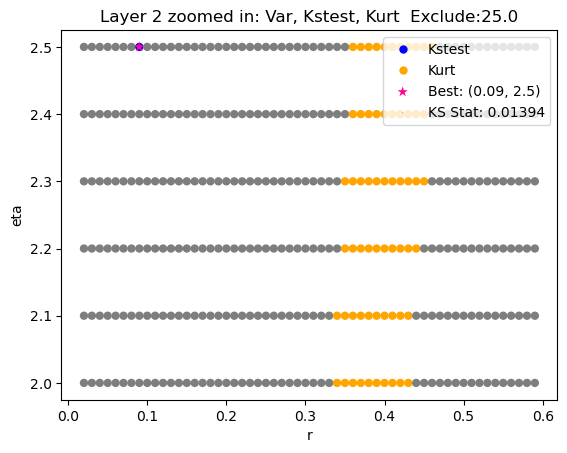

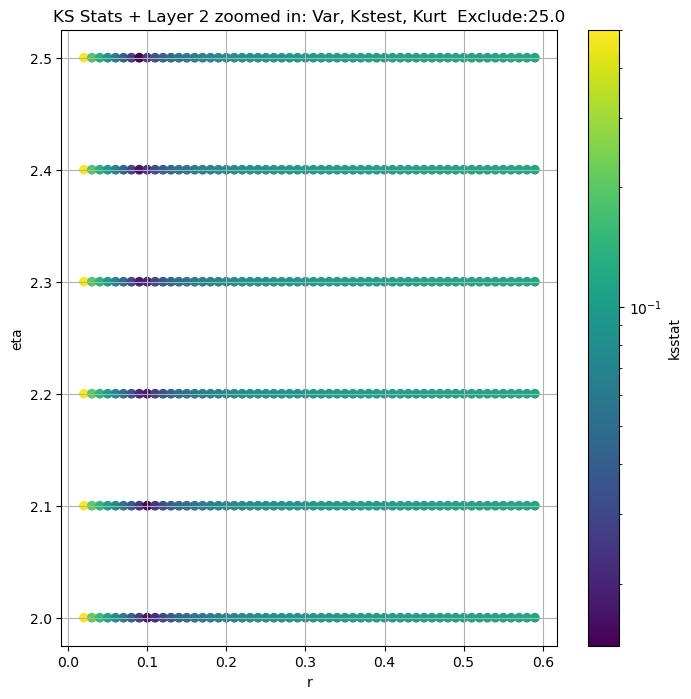

Layer 3


100%|██████████| 580/580 [00:00<00:00, 684.07it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 100 = 300, ksstat: 0.015954349441736015, var: 8160.31982421875


100%|██████████| 580/580 [00:00<00:00, 802.19it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 75 = 275, ksstat: 0.014973539709174588, var: 8481.3662109375


100%|██████████| 580/580 [00:00<00:00, 798.58it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 50 = 250, ksstat: 0.013948578459799688, var: 8833.767578125


100%|██████████| 580/580 [00:00<00:00, 769.42it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 25 = 225, ksstat: 0.013298133148299474, var: 9224.3681640625


100%|██████████| 580/580 [00:00<00:00, 790.85it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 0 = 200, ksstat: 0.013127038969653282, var: 9663.3583984375


100%|██████████| 580/580 [00:00<00:00, 793.64it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -25 = 175, ksstat: 0.01348950720404607, var: 10158.3310546875


100%|██████████| 580/580 [00:00<00:00, 780.48it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -50 = 150, ksstat: 0.013810697149131634, var: 10732.189453125


100%|██████████| 580/580 [00:00<00:00, 809.69it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -75 = 125, ksstat: 0.013579225969581832, var: 11404.96875


100%|██████████| 580/580 [00:00<00:00, 738.20it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -100 = 100, ksstat: 0.014178561687838709, var: 12236.73046875
Number of samples: 36000, Without approximation : 36000.0


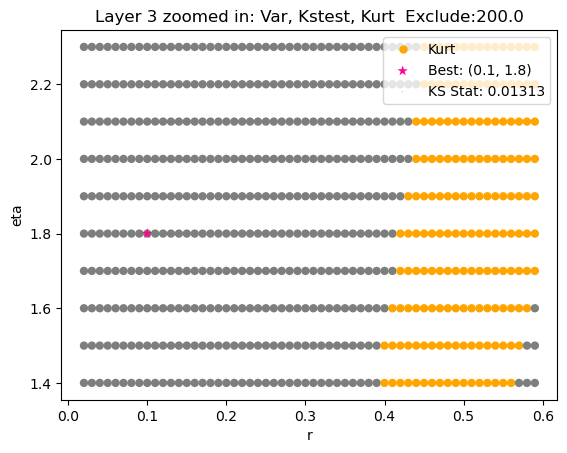

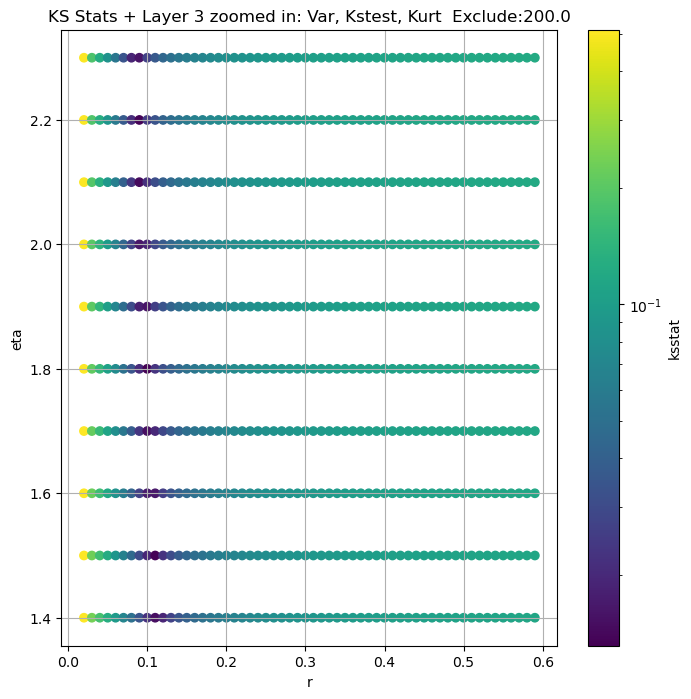

Layer 4


100%|██████████| 522/522 [00:02<00:00, 243.15it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.010381473236499184, var: 1844.86767578125


100%|██████████| 522/522 [00:01<00:00, 268.01it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.01008937445779623, var: 1880.7022705078125


100%|██████████| 522/522 [00:01<00:00, 268.08it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.009732442852846246, var: 1918.5064697265625


100%|██████████| 522/522 [00:01<00:00, 271.85it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.009470961219725571, var: 1958.406982421875


100%|██████████| 522/522 [00:01<00:00, 269.29it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.009163613864520692, var: 2000.5931396484375


100%|██████████| 522/522 [00:01<00:00, 272.94it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.008760284242539718, var: 2045.0675048828125


100%|██████████| 522/522 [00:01<00:00, 268.46it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.008517917685582854, var: 2092.21875


100%|██████████| 522/522 [00:01<00:00, 270.23it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.008078557258035413, var: 2142.12744140625


100%|██████████| 522/522 [00:01<00:00, 270.41it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.008050695912777156, var: 2194.888671875
Number of samples: 100000, Without approximation : 144000.0


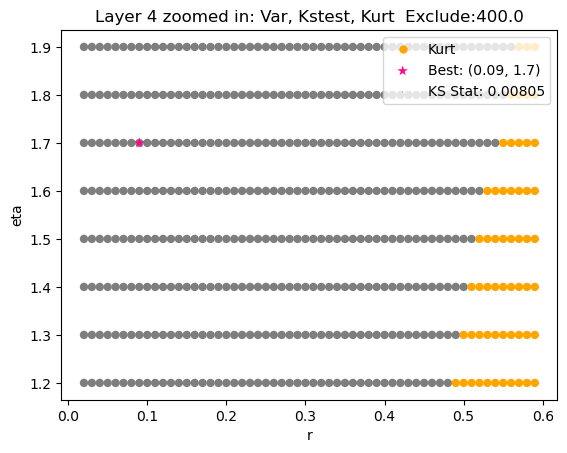

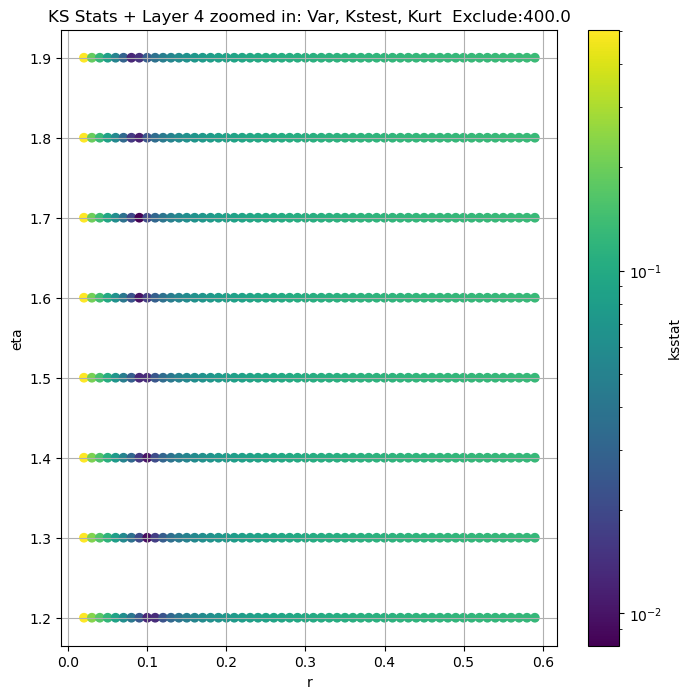

Layer 5


100%|██████████| 522/522 [00:02<00:00, 260.18it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.007840358743925524, var: 380.14373779296875


100%|██████████| 522/522 [00:01<00:00, 268.24it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007520107901120121, var: 389.21881103515625


100%|██████████| 522/522 [00:01<00:00, 265.38it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.007178512808579951, var: 398.9101867675781


100%|██████████| 522/522 [00:01<00:00, 270.26it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.006864022379047374, var: 409.2980651855469


100%|██████████| 522/522 [00:01<00:00, 270.21it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.006592574221024217, var: 420.56781005859375


100%|██████████| 522/522 [00:01<00:00, 275.67it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.006447979687318917, var: 432.80450439453125


100%|██████████| 522/522 [00:01<00:00, 273.74it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.006850485079937685, var: 446.1991882324219


100%|██████████| 522/522 [00:01<00:00, 275.04it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.006867515514099032, var: 460.9164123535156


100%|██████████| 522/522 [00:01<00:00, 273.63it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.007882341219130978, var: 477.08441162109375
Number of samples: 100000, Without approximation : 576000.0


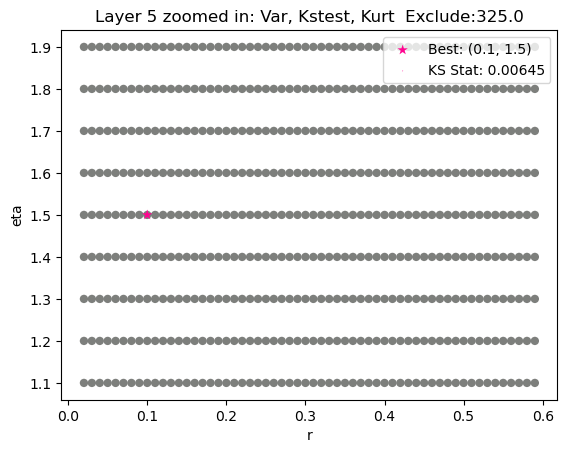

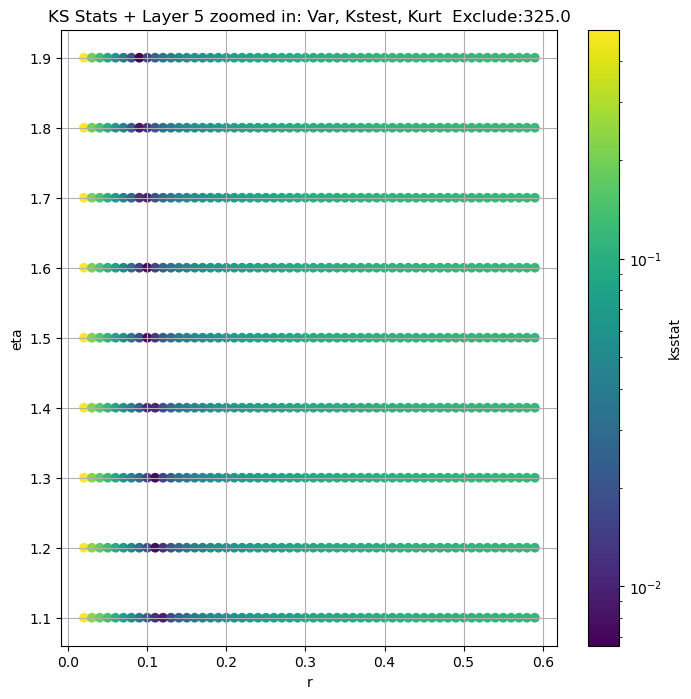

Layer 6


100%|██████████| 580/580 [00:02<00:00, 257.42it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.006064787846185471, var: 82.37035369873047


100%|██████████| 580/580 [00:02<00:00, 262.56it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.005730965767509644, var: 84.27587890625


100%|██████████| 580/580 [00:02<00:00, 274.85it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.005382134561541574, var: 86.3364486694336


100%|██████████| 580/580 [00:02<00:00, 273.79it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.005073694017224684, var: 88.58570861816406


100%|██████████| 580/580 [00:02<00:00, 273.24it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.00471811304706804, var: 91.0543441772461


100%|██████████| 580/580 [00:02<00:00, 271.45it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.0043935070111623675, var: 93.7691879272461


100%|██████████| 580/580 [00:02<00:00, 273.40it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.004538671175899747, var: 96.79618072509766


100%|██████████| 580/580 [00:02<00:00, 267.46it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.005453530257685468, var: 100.20767211914062


100%|██████████| 580/580 [00:02<00:00, 275.63it/s]


Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.0058934639920606435, var: 104.11361694335938
Number of samples: 100000, Without approximation : 2304000.0


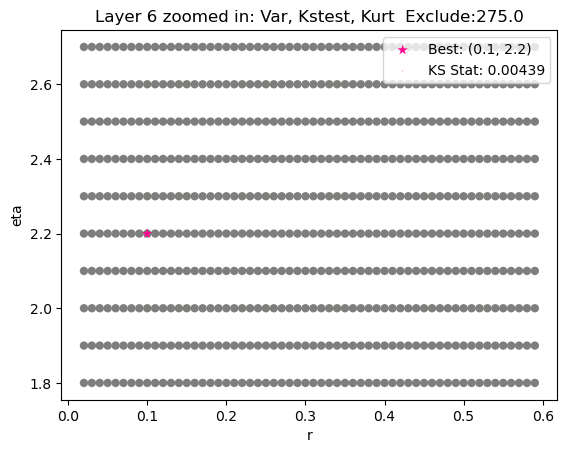

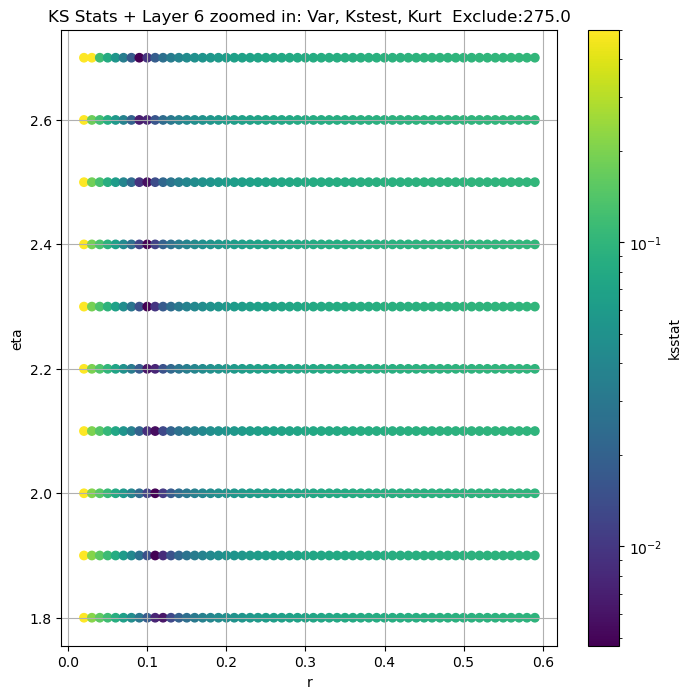

Layer 7


100%|██████████| 621/621 [00:02<00:00, 246.18it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.004971134058796123, var: 21.78437614440918


100%|██████████| 621/621 [00:02<00:00, 261.48it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.004660677561570625, var: 22.220735549926758


100%|██████████| 621/621 [00:02<00:00, 272.76it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.004331850572723672, var: 22.697040557861328


100%|██████████| 621/621 [00:02<00:00, 274.42it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.004004642466739594, var: 23.22118377685547


100%|██████████| 621/621 [00:02<00:00, 271.86it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.0038594083067428064, var: 23.804391860961914


100%|██████████| 621/621 [00:02<00:00, 273.67it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.0037799999999983402, var: 24.458982467651367


100%|██████████| 621/621 [00:02<00:00, 275.47it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.0038641672577722774, var: 25.20555305480957


100%|██████████| 621/621 [00:02<00:00, 274.31it/s]


Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.0049872952278307014, var: 26.07337188720703


100%|██████████| 621/621 [00:02<00:00, 271.86it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.0050745177466196, var: 27.104928970336914
Number of samples: 100000, Without approximation : 9216000.0


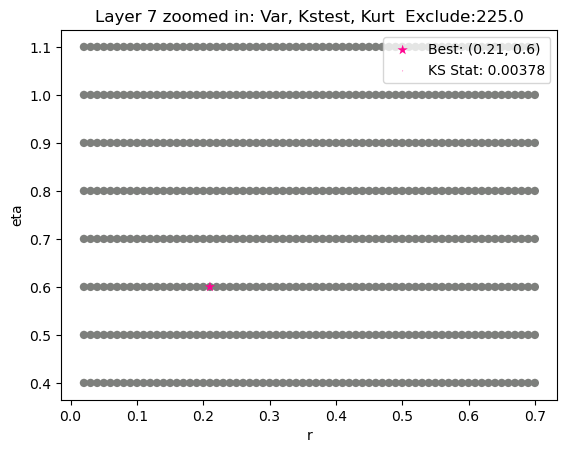

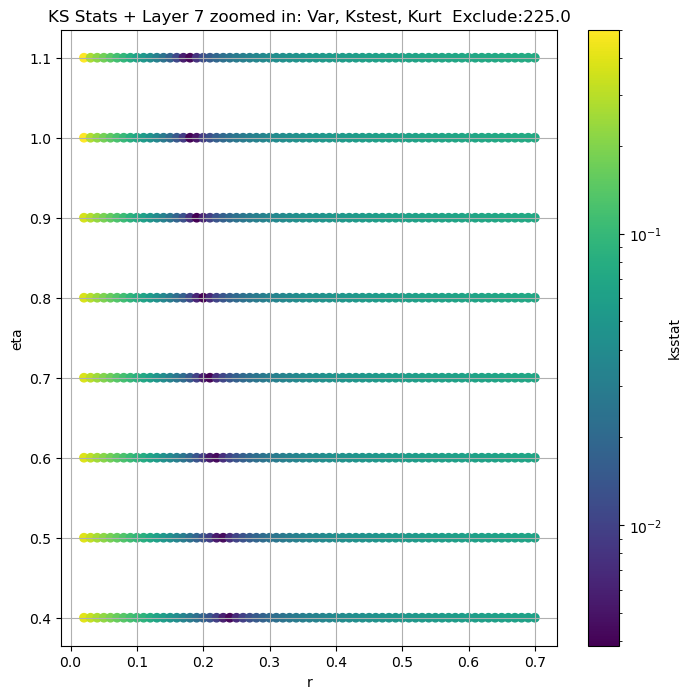

Layer 8


100%|██████████| 522/522 [00:01<00:00, 265.78it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 100 = 200, ksstat: 0.0033499999999981878, var: 10.253602981567383


100%|██████████| 522/522 [00:01<00:00, 267.40it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 75 = 175, ksstat: 0.0033499999999976326, var: 10.548418045043945


100%|██████████| 522/522 [00:01<00:00, 275.66it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 50 = 150, ksstat: 0.0033499999999971886, var: 10.898865699768066


100%|██████████| 522/522 [00:01<00:00, 275.30it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 25 = 125, ksstat: 0.0033500000000000196, var: 11.332098007202148


100%|██████████| 522/522 [00:01<00:00, 270.83it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 0 = 100, ksstat: 0.003349999999999964, var: 11.896943092346191


100%|██████████| 522/522 [00:01<00:00, 275.90it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -25 = 75, ksstat: 0.003497685875051726, var: 12.692532539367676


100%|██████████| 522/522 [00:01<00:00, 275.65it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -50 = 50, ksstat: 0.005749528325273645, var: 13.967172622680664


100%|██████████| 522/522 [00:01<00:00, 270.40it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -75 = 25, ksstat: 0.00929784763123176, var: 16.51028823852539


100%|██████████| 522/522 [00:01<00:00, 273.61it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -100 = 0, ksstat: 0.021961147533652525, var: 33.17373275756836
Number of samples: 100000, Without approximation : 36864000.0


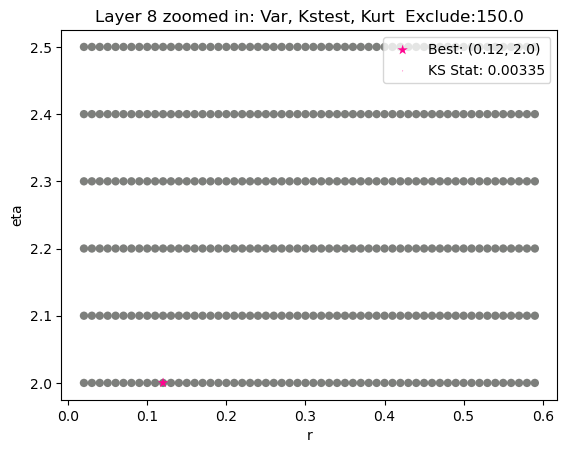

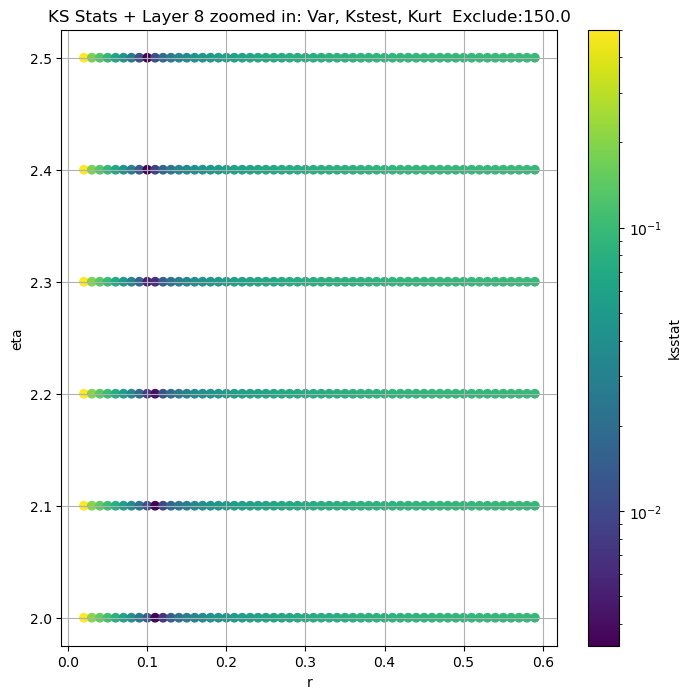

Layer 9


100%|██████████| 522/522 [00:02<00:00, 256.76it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + 100 = 175, ksstat: 0.005949999999982913, var: 2.90889310836792


100%|██████████| 522/522 [00:01<00:00, 273.57it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + 75 = 150, ksstat: 0.005949999999982469, var: 3.007298469543457


100%|██████████| 522/522 [00:01<00:00, 274.98it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + 50 = 125, ksstat: 0.005949999999982913, var: 3.1269397735595703


100%|██████████| 522/522 [00:01<00:00, 270.52it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + 25 = 100, ksstat: 0.0059499999999831354, var: 3.2806262969970703


100%|██████████| 522/522 [00:01<00:00, 274.52it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + 0 = 75, ksstat: 0.005949999999996014, var: 3.4964396953582764


100%|██████████| 522/522 [00:01<00:00, 272.65it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + -25 = 50, ksstat: 0.006680915110119701, var: 3.8481075763702393


100%|██████████| 522/522 [00:01<00:00, 272.07it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + -50 = 25, ksstat: 0.009995055024737631, var: 4.574733734130859


100%|██████████| 522/522 [00:01<00:00, 276.10it/s]


Finding Minimum after computing 522 CDFs
layer 9, 75.0 + -75 = 0, ksstat: 0.025809706732917603, var: 11.25263500213623
Number of samples: 100000, Without approximation : 147456000.0


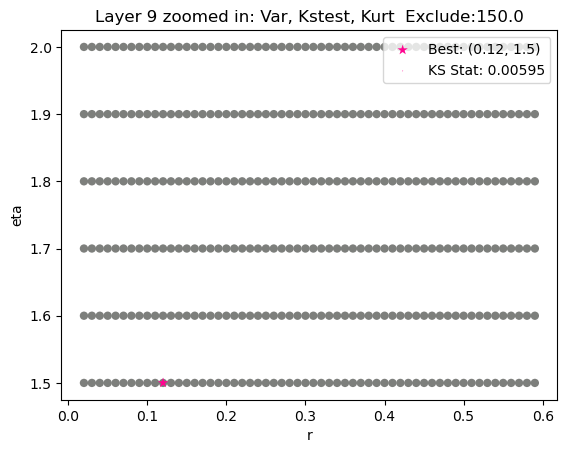

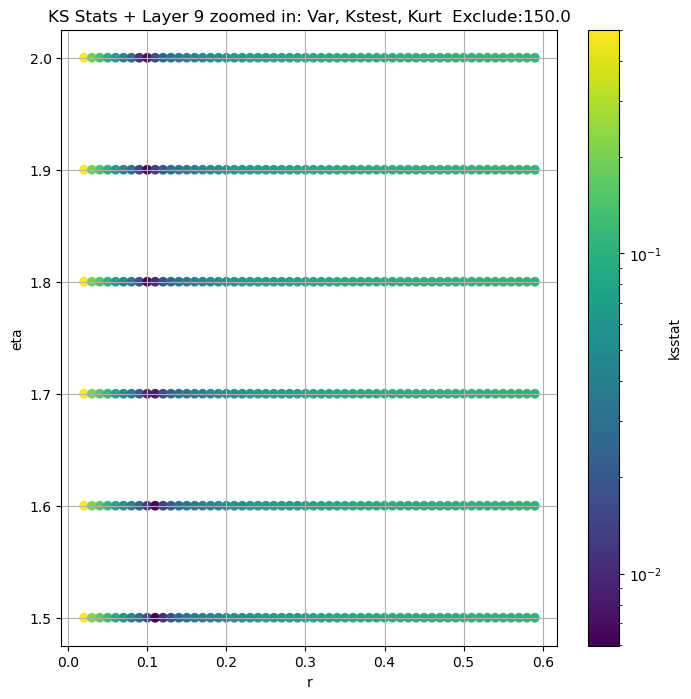

Layer 10


100%|██████████| 1410/1410 [00:05<00:00, 245.16it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 100 = 125, ksstat: 0.026099999999980583, var: 0.44054657220840454


100%|██████████| 1410/1410 [00:05<00:00, 258.82it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 75 = 100, ksstat: 0.026099999999980472, var: 0.4631687104701996


100%|██████████| 1410/1410 [00:05<00:00, 273.47it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 50 = 75, ksstat: 0.026099999999980417, var: 0.4942845106124878


100%|██████████| 1410/1410 [00:05<00:00, 276.52it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 25 = 50, ksstat: 0.02609999999998447, var: 0.5432801842689514


100%|██████████| 1410/1410 [00:05<00:00, 278.75it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 0 = 25, ksstat: 0.02609999999998741, var: 0.6416746973991394


100%|██████████| 1410/1410 [00:05<00:00, 278.10it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + -25 = 0, ksstat: 0.03520388144039188, var: 1.875914216041565
Number of samples: 100000, Without approximation : 589824000.0


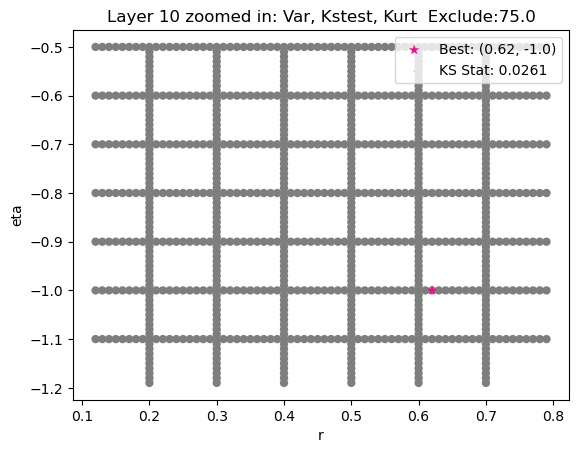

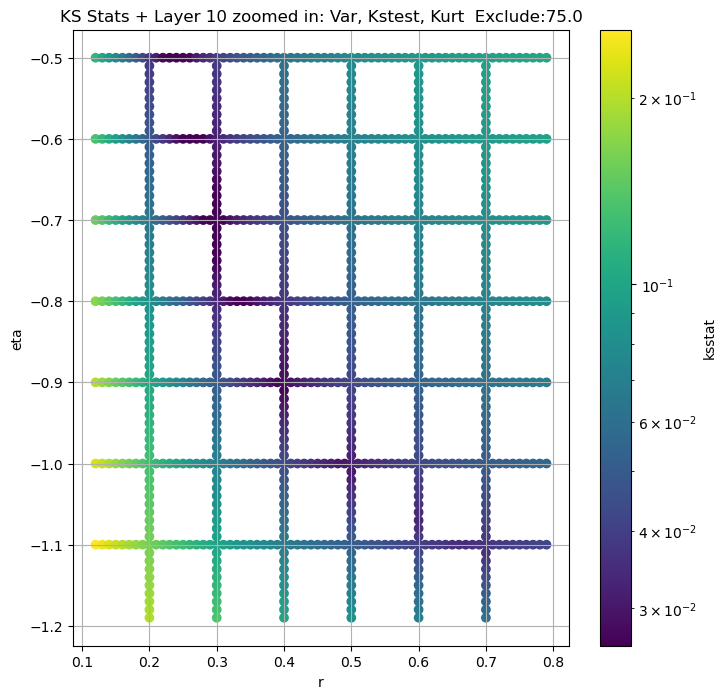

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       760.94360         9000.0             0.014584        0.1          2.1   
3       891.27313        36000.0             0.013127        0.1          1.8   
4      1768.95340       144000.0             0.009242        0.1          1.5   
5      2074.88330       576000.0             0.006941        0.1          1.5   
6      3444.52950      2304000.0             0.004749        0.1          2.3   
7      5672.12000      9216000.0             0.003924        0.2          0.8   
8      4638.63770     36864000.0             0.003350        0.1          2.4   
9      6105.37160    147456000.0             0.005950        0.1          1.9   
10     7496.85840    589824000.0             0.026100        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.600289e-12                    25.0        53255.480469   
3       1.809763e-12                   200.0         9663.358000   
4       8.671865e-13                   500.0         2194.888672   
5       1.823013e-13                   350.0          432.804504   
6       4.845850e-15                   300.0           93.769188   
7       5.457777e-05                   250.0           24.458982   
8       5.012416e-16                   100.0           10.898866   
9       5.025335e-16                    75.0            3.007298   
10      8.045400e-03                    25.0            0.494285   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.013944    0.09       2.5   
3                     0.007153          0.013127    0.10       1.8   
4                     0.003578          0.008051    0.09       1.7   
5                     0.001789          0.006448    0.10       1.5   
6                     0.000895          0.004394    0.10       2.2   
7                     0.000447          0.003780    0.21       0.6   
8                     0.000224          0.003350    0.12       2.0   
9                     0.000112          0.005950    0.12       1.5   
10                    0.000056          0.026100    0.62      -1.0   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      8.081718e-15                 25.0       9000.0  
3      1.809763e-12                200.0      10807.0  
4      3.038032e-15                400.0      28830.0  
5      1.876055e-13                325.0      45562.0  
6      6.339071e-15                275.0      91125.0  
7      1.920775e-04                225.0     136687.0  
8      2.576572e-12                150.0     162000.0  
9      2.218216e-12                150.0      54000.0  
10     4.545921e-01                 75.0       2845.0

In [20]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

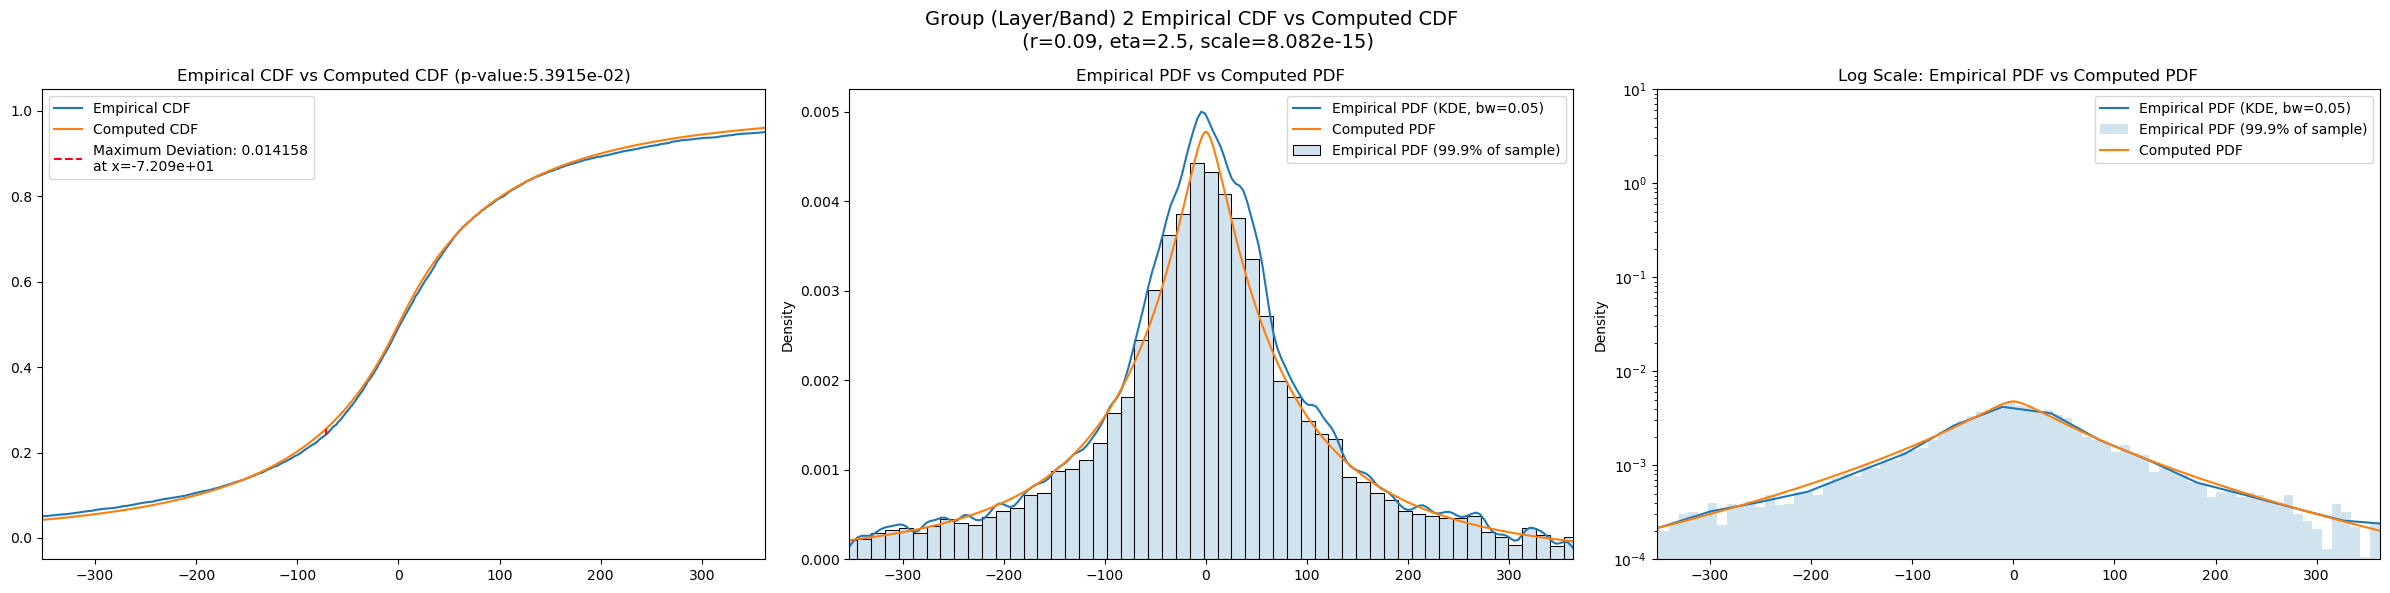

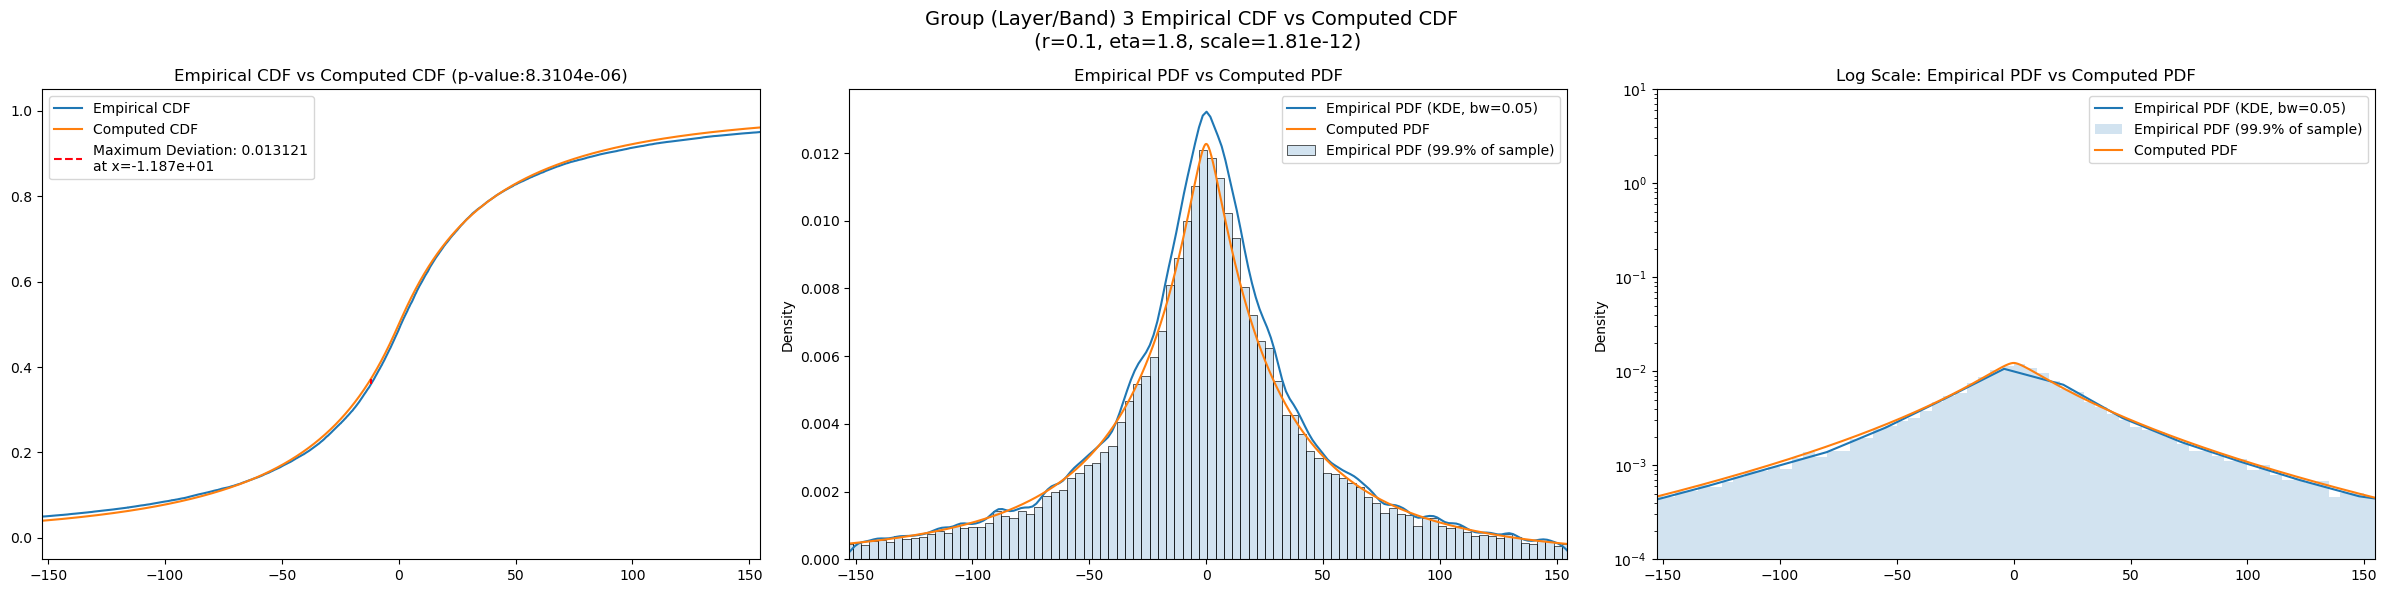

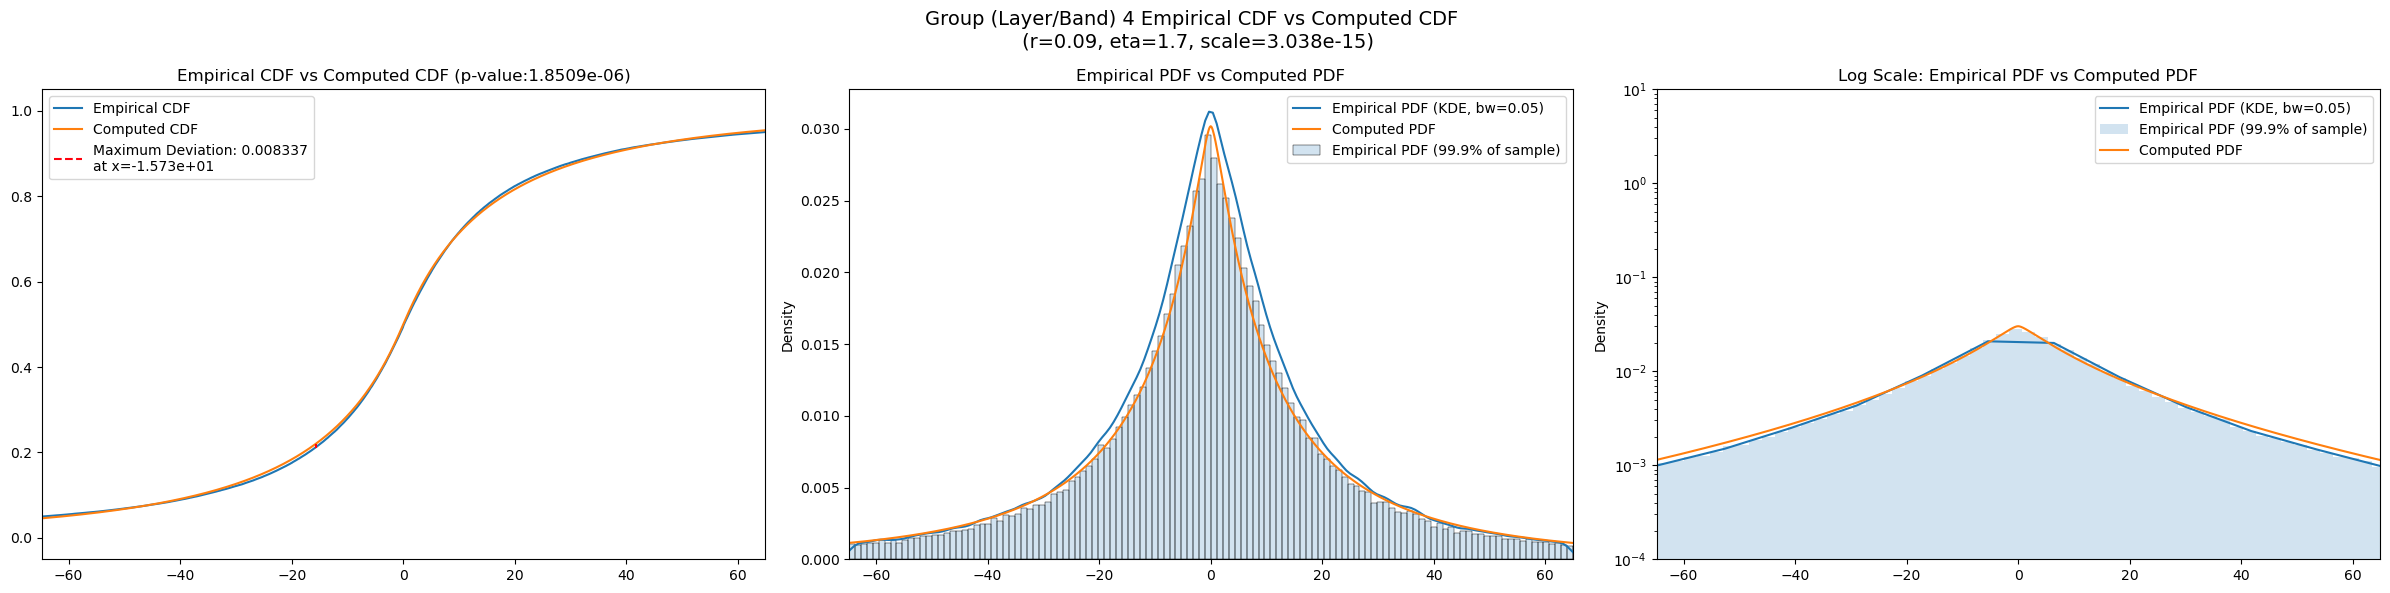

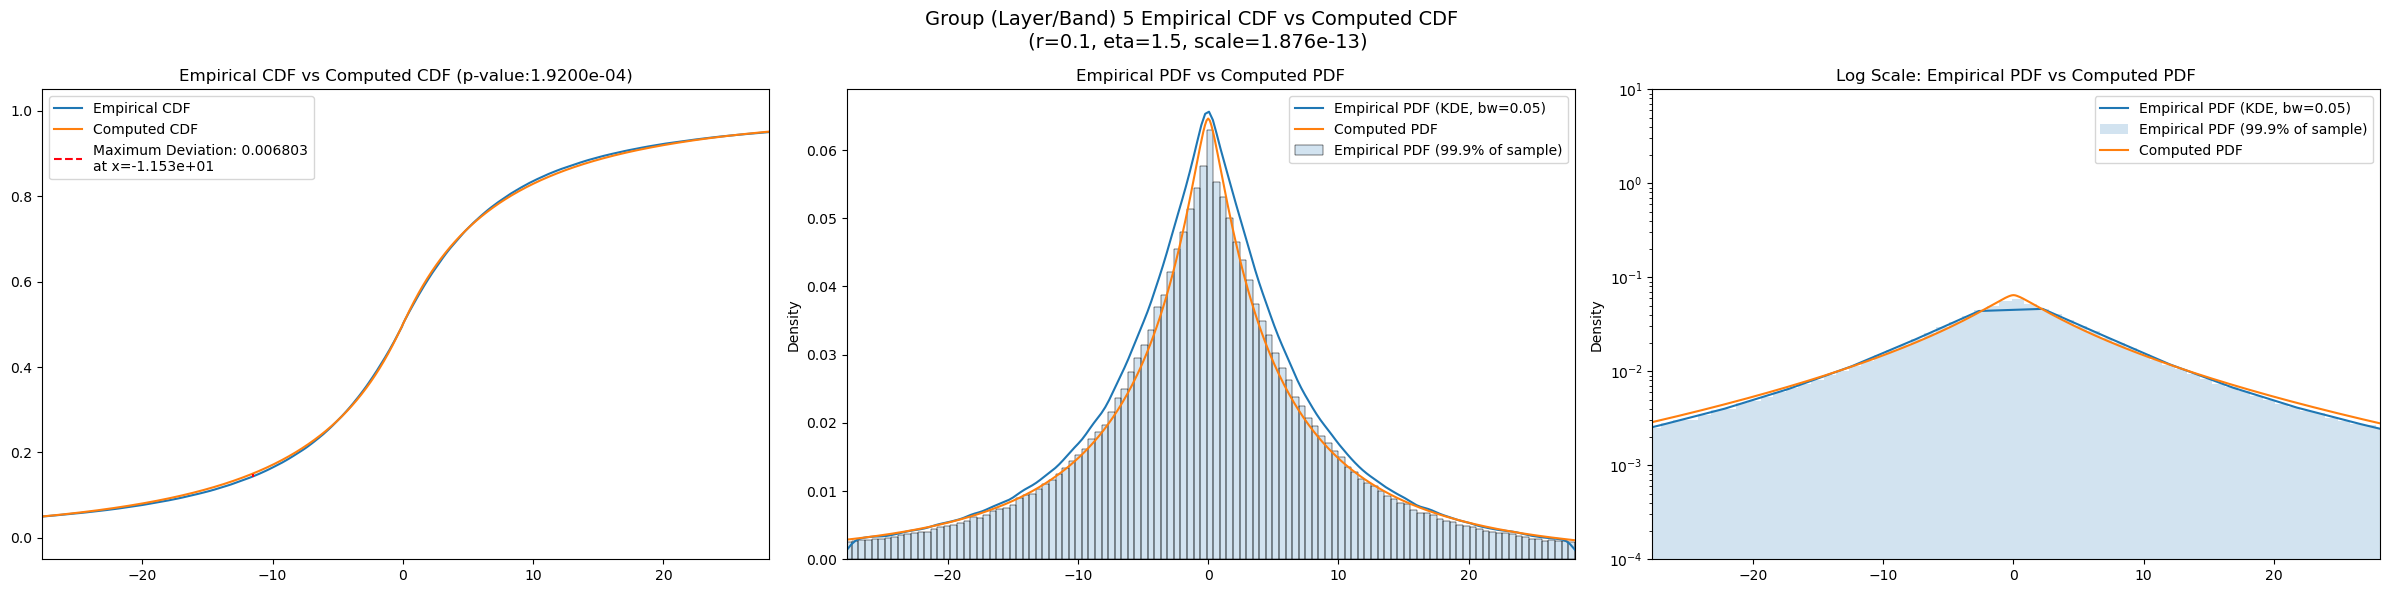

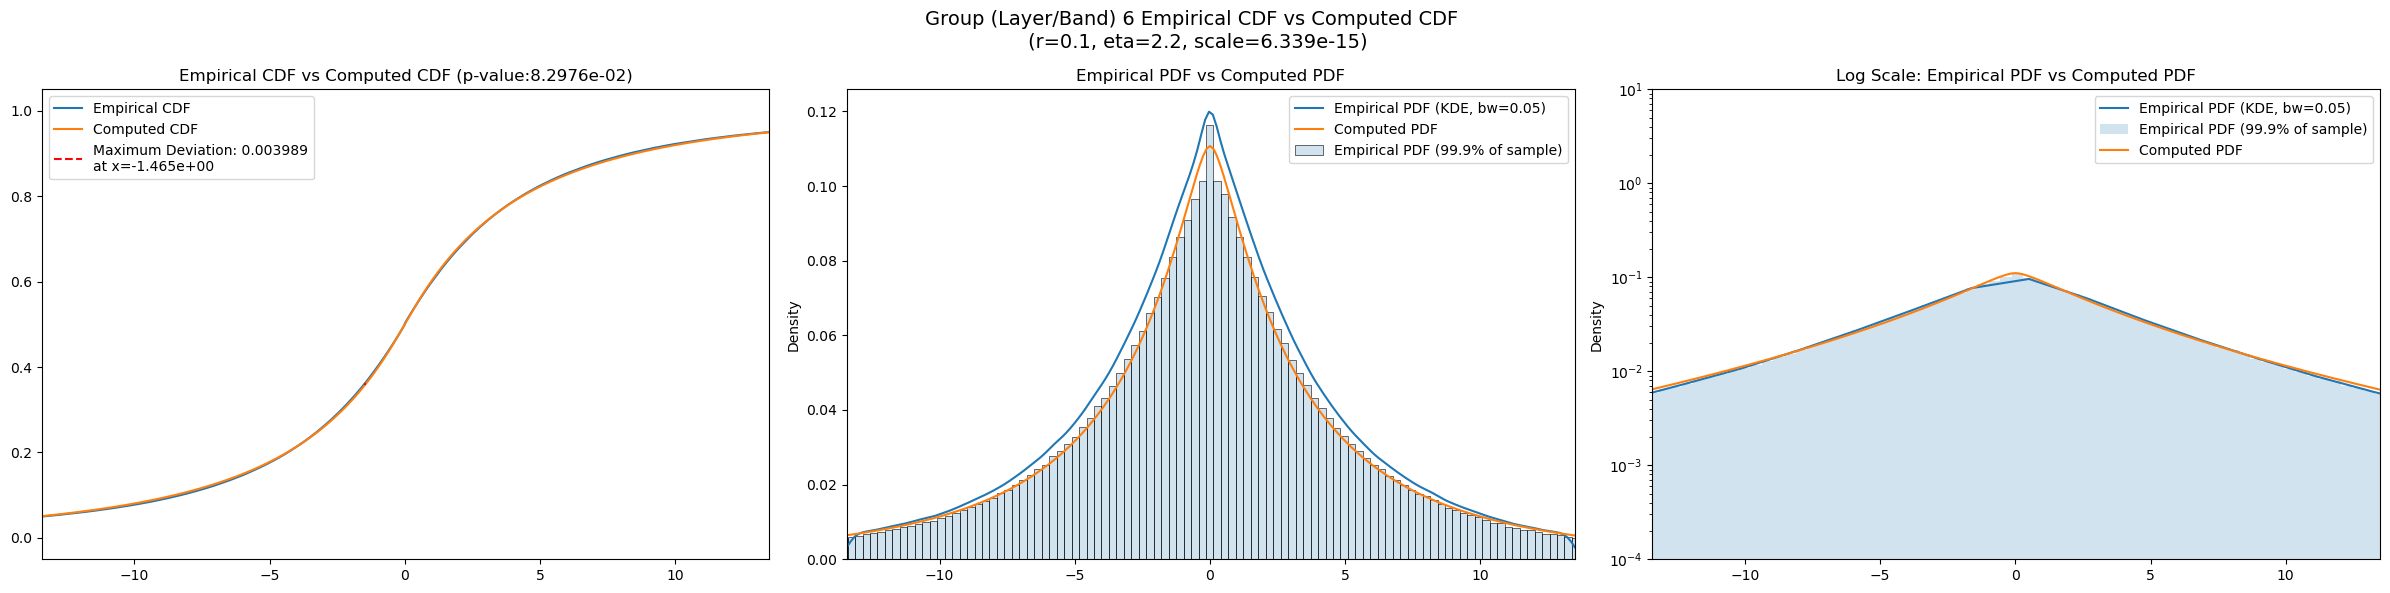

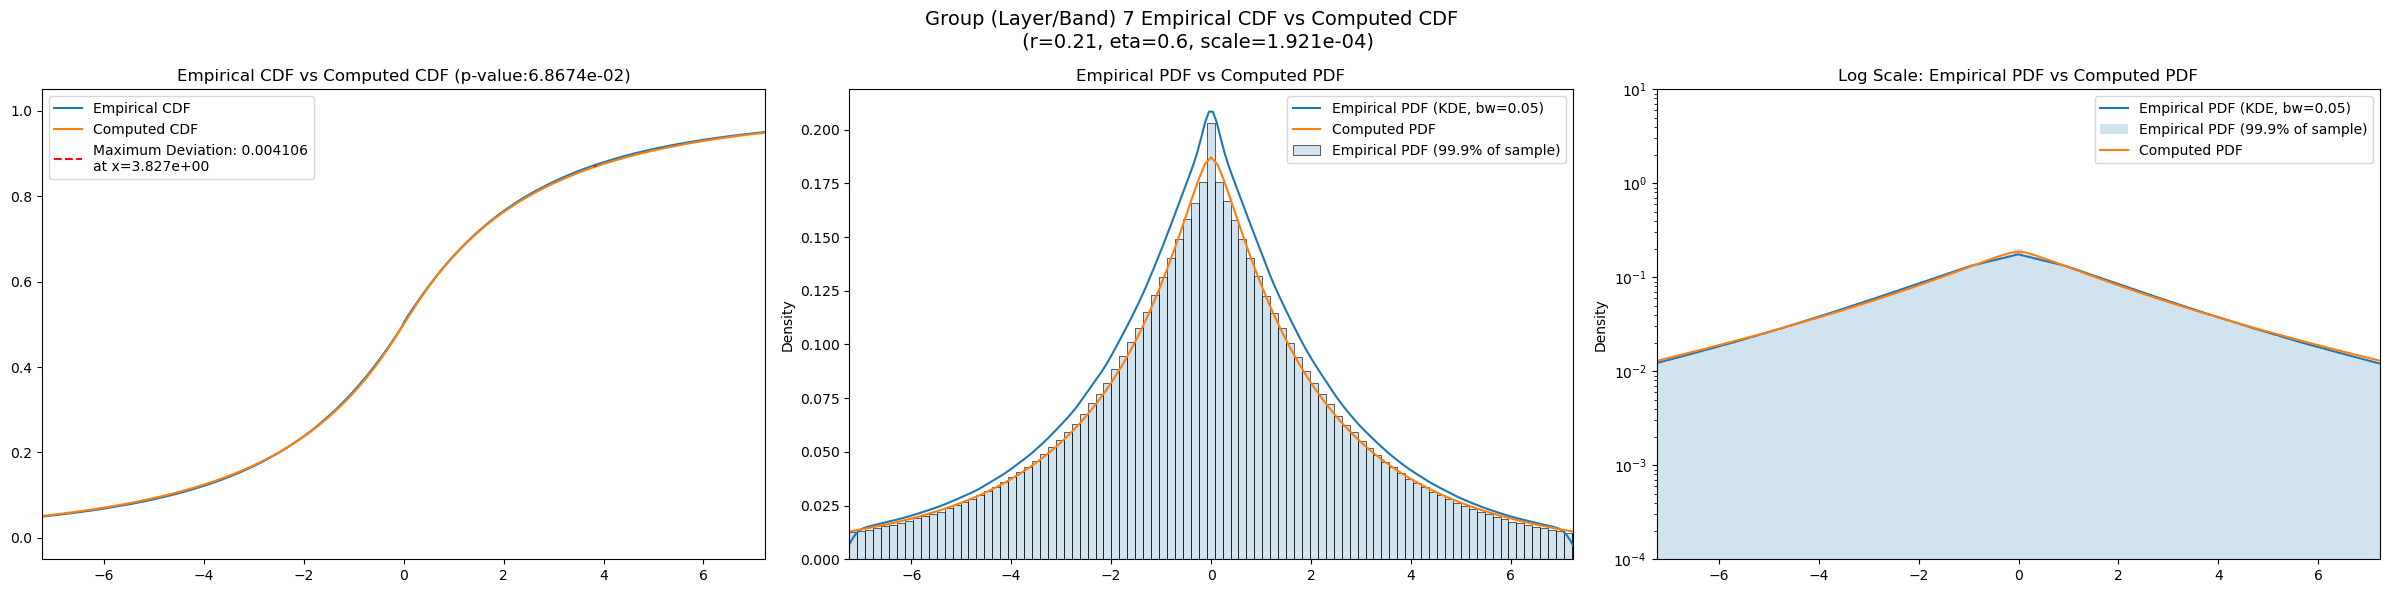

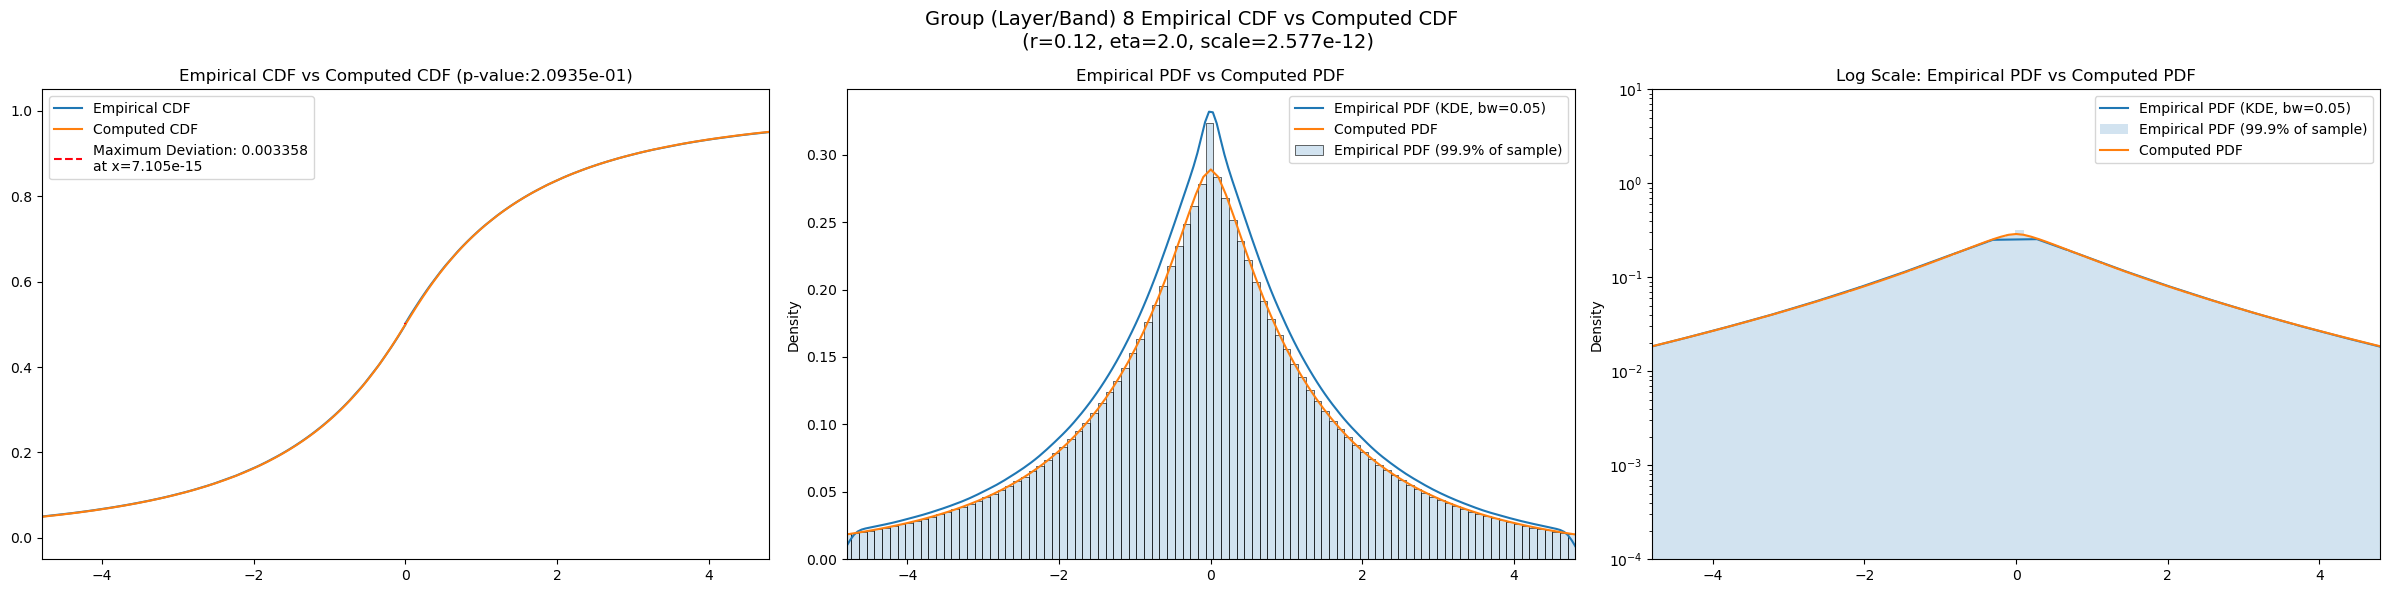

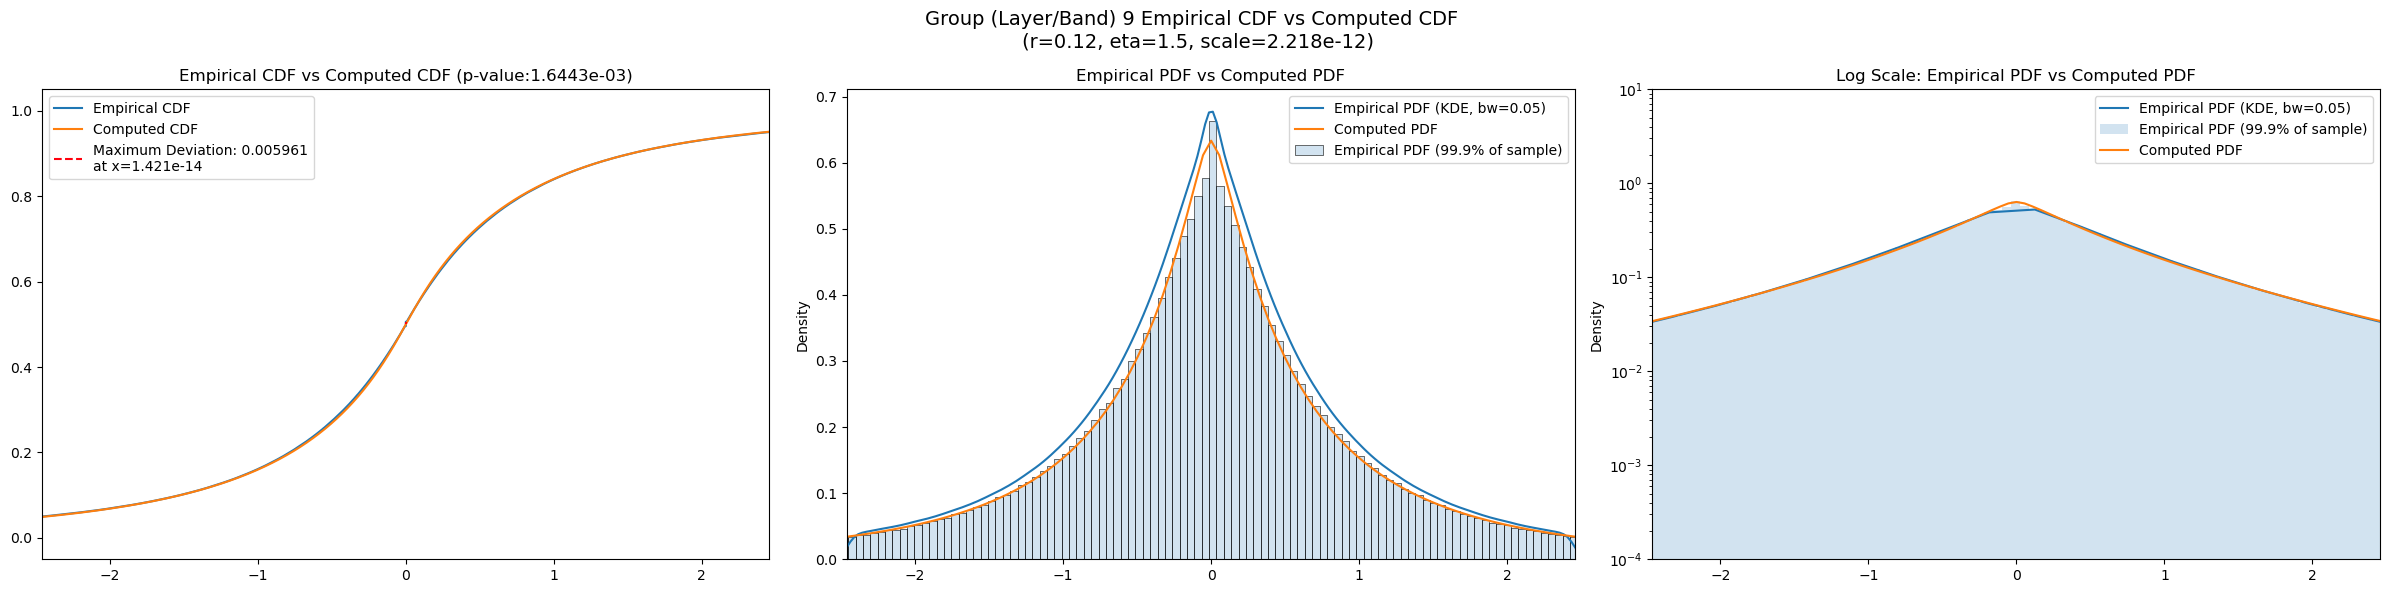

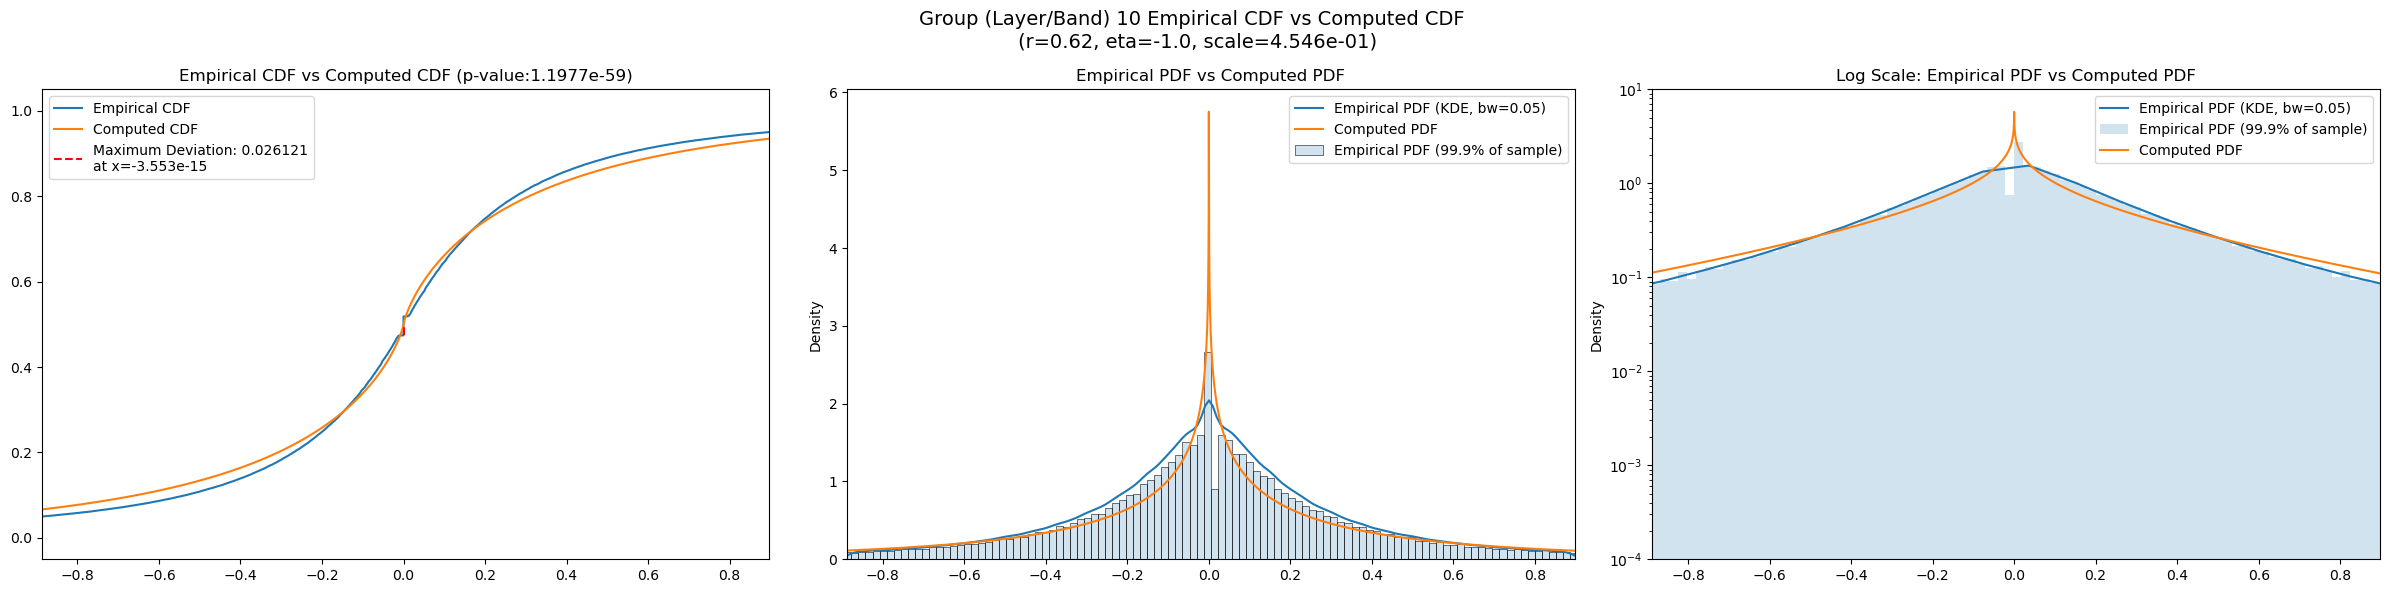

In [21]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [22]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [23]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188570.730000  99638.340000  330262.220000   536.03296  113.304540   
3       42568.312000  23773.760000   71607.330000   488.99530  135.974520   
4       10773.336000   5322.670000   20877.791000   785.24280  131.392270   
5        1800.434900    923.853000    3624.655000   858.03740  109.913740   
6         390.887500    183.288650     971.469850  1521.53970  104.035530   
7          98.479220     41.024357     351.604030  3306.70500   84.348870   
8          33.173733     15.926921     100.374084  2264.61400   78.321760   
9          11.252635      4.427865      43.877705  5137.09860   82.329865   
10          1.875914      0.615992      10.184826  9775.98100   78.684250   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       760.94360         9000.0             0.014584        0.1          2.1   
3       891.27313        36000.0             0.013127        0.1          1.8   
4      1768.95340       144000.0             0.009242        0.1          1.5   
5      2074.88330       576000.0             0.006941        0.1          1.5   
6      3444.52950      2304000.0             0.004749        0.1          2.3   
7      5672.12000      9216000.0             0.003924        0.2          0.8   
8      4638.63770     36864000.0             0.003350        0.1          2.4   
9      6105.37160    147456000.0             0.005950        0.1          1.9   
10     7496.85840    589824000.0             0.026100        0.3         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      131.899000              0.055415          1.834910e-24   
3      ...       53.584400              0.057770         7.115700e-105   
4      ...       23.148600              0.054251          0.000000e+00   
5      ...       10.882500              0.048652          0.000000e+00   
6      ...        5.731200              0.042154          0.000000e+00   
7      ...        3.212460              0.039117          0.000000e+00   
8      ...        2.081460              0.041292          0.000000e+00   
9      ...        1.034170              0.043593          0.000000e+00   
10     ...        0.361633              0.046655          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         116.308000             0.029473         3.166700e-07  93.613400   
3          47.514500             0.031681         7.939590e-32  37.265100   
4          20.677300             0.028975        1.831090e-105  16.103000   
5           9.712140             0.023931        5.558780e-287   7.601830   
6           5.101670             0.017177         0.000000e+00   4.012160   
7           2.846970             0.013100         0.000000e+00   2.265980   
8           1.837490             0.014487         0.000000e+00   1.467140   
9           0.914581             0.017191         0.000000e+00   0.725643   
10          0.298702             0.026100         0.000000e+00   0.237466   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.026207   8.390310e-06          5.983964e-02  
3           0.030362   2.889150e-29          8.105383e-06  
4           0.024964   2.153860e-78          1.555619e-08  
5           0.018934  8.485670e-180          3.147631e-21  
6           0.013458   0.000000e+00          4.679802e-39  
7           0.012420   0.000000e+00         8.365567e-115  
8           0.014351   0.000000e+00          0.000000e+00  
9           0.015611   0.000000e+00          0.000000e+00  
10        

## Results

In [24]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [25]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.014584                 0.014297          0.013944   
3                 0.013127                 0.007153          0.013127   
4                 0.009242                 0.003578          0.008051   
5                 0.006941                 0.001789          0.006448   
6                 0.004749                 0.000895          0.004394   
7                 0.003924                 0.000447          0.003780   
8                 0.003350                 0.000224          0.003350   
9                 0.005950                 0.000112          0.005950   
10                0.026100                 0.000056          0.026100   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.055415             0.029473       0.026207  
3                  0.057770             0.031681       0.030362  
4                  0.054251             0.028975       0.024964  
5                  0.048652             0.023931       0.018934  
6                  0.042154             0.017177       0.013458  
7                  0.039117             0.013100       0.012420  
8                  0.041292             0.014487       0.014351  
9                  0.043593             0.017191       0.015611  
10                 0.046655             0.026100       0.026100

In [26]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            53255.480469          0.013944    0.09       2.5  8.081718e-15   
3             9663.358000          0.013127    0.10       1.8  1.809763e-12   
4             2194.888672          0.008051    0.09       1.7  3.038032e-15   
5              432.804504          0.006448    0.10       1.5  1.876055e-13   
6               93.769188          0.004394    0.10       2.2  6.339071e-15   
7               24.458982          0.003780    0.21       0.6  1.920775e-04   
8               10.898866          0.003350    0.12       2.0  2.576572e-12   
9                3.007298          0.005950    0.12       1.5  2.218216e-12   
10               0.494285          0.026100    0.62      -1.0  4.545921e-01   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    200.0  
4                    400.0  
5                    325.0  
6                    275.0  
7                    225.0  
8                    150.0  
9                    150.0  
10                    75.0

In [27]:
eng.quit()